In [1]:
## loading package 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib import pylab
import seaborn as sns 
from sklearn.metrics.pairwise import cosine_similarity
from statannot import add_stat_annotation
import matplotlib as mpl
from scipy import stats, cluster
import glob
import re
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats import multitest
from matplotlib.gridspec import GridSpec

from matplotlib_venn import venn2, venn3
from matplotlib import pyplot as plt

import warnings 
warnings.simplefilter('ignore')

## load_large_dataFrame
def load_large_dataFrame(input_file, sep=",", header=0, index_col=0, chunksize=100000, compressed=False):
    if compressed:
        TextFileReader = pd.read_csv(input_file, chunksize=chunksize, sep=sep, header=header,index_col=index_col, compression='gzip')
    else:
        TextFileReader = pd.read_csv(input_file, chunksize=chunksize, sep=sep, header=header,index_col=index_col)
    dfList=[]
    for df in TextFileReader:
        dfList.append(df)
    final_df = pd.concat(dfList,sort=False)
    return final_df

In [2]:
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

# Check Accuracy
    1) Kevin Weeks
        Guidelines for SHAPE Reagent Choice and Detection Strategy for RNA Structure Probing Studies
        S. Busan, C. A. Weidmann, A. Sengupta and K. M. Weeks
        Biochemistry 2019 Vol. 58 Issue 23 Pages 2655-2664
        DOI: 10.1021/acs.biochem.8b01218


## 1.Load Kevins shapemap results

### 1.1 Load secondary structures

#### 1.1.1 mouse

In [4]:
with open("../Data/09.SHAPE_accuracy/mouse/mouse/mouse_small.dot") as f:
    for l in f:
        if l[0] == ">":
            name = l[1:].strip("\n")
        elif l[0] in ['A','T','C','G','U']:
            seq = list(l.strip("\n"))
        elif l[0] in ['.','(',')',"<",">"]:
            dotbrackets = list(l.strip("\n"))
mus_rRNA_dotbrackets_df = pd.DataFrame([seq, dotbrackets]).T
mus_rRNA_dotbrackets_df.columns = ['seq','dotbracket']
print (mus_rRNA_dotbrackets_df.iloc[18:21])
mus_rRNA_dotbrackets_df['Nucleotide'] = list(range(0, mus_rRNA_dotbrackets_df.index.size))
mus_rRNA_dotbrackets_df['unpair'] = 0
mus_rRNA_dotbrackets_df.loc[mus_rRNA_dotbrackets_df['dotbracket']==".", 'unpair'] = 1
mus_rRNA_dotbrackets_df = mus_rRNA_dotbrackets_df.set_index('Nucleotide')
#mus_rRNA_dotbrackets_df

   seq dotbracket
18   A          )
19   G          )
20   G          .


#### 1.1.2 human

In [5]:
with open("../Data/09.SHAPE_accuracy/human_18S.dot") as f:
    for l in f:
        if l[0] == ">":
            name = l[1:].strip("\n")
        elif l[0] in ['A','T','C','G','U']:
            seq = list(l.strip("\n"))
        elif l[0] in ['.','(',')',"<",">"]:
            dotbrackets = list(l.strip("\n"))
hg_rRNA_dotbrackets_df = pd.DataFrame([seq, dotbrackets]).T
hg_rRNA_dotbrackets_df.columns = ['seq','dotbracket']
print (hg_rRNA_dotbrackets_df.iloc[18:21])
hg_rRNA_dotbrackets_df['Nucleotide'] = list(range(1, hg_rRNA_dotbrackets_df.index.size+1))
hg_rRNA_dotbrackets_df['unpair'] = 0
hg_rRNA_dotbrackets_df.loc[hg_rRNA_dotbrackets_df['dotbracket']==".", 'unpair'] = 1
hg_rRNA_dotbrackets_df = hg_rRNA_dotbrackets_df.set_index('Nucleotide')
#hg_rRNA_dotbrackets_df

   seq dotbracket
18   A          )
19   G          )
20   U          .


In [109]:
with open("../../../../FigureFactory/rRNA_ROC/human_18S.dot") as f:
    for l in f:
        if l[0] == ">":
            name = l[1:].strip("\n")
        elif l[0] in ['A','T','C','G','U']:
            seq = list(l.strip("\n"))
        elif l[0] in ['.','(',')',"<",">"]:
            dotbrackets = list(l.strip("\n"))
hg_rRNA_dotbrackets_df = pd.DataFrame([seq, dotbrackets]).T
hg_rRNA_dotbrackets_df.columns = ['seq','dotbracket']
print (hg_rRNA_dotbrackets_df.iloc[18:21])
hg_rRNA_dotbrackets_df['Nucleotide'] = list(range(1, hg_rRNA_dotbrackets_df.index.size+1))
hg_rRNA_dotbrackets_df['unpair'] = 0
hg_rRNA_dotbrackets_df.loc[hg_rRNA_dotbrackets_df['dotbracket']==".", 'unpair'] = 1
hg_rRNA_dotbrackets_df = hg_rRNA_dotbrackets_df.set_index('Nucleotide')
# hg_rRNA_dotbrackets_df.index = list(range(hg_rRNA_dotbrackets_df.index.size))
#hg_rRNA_dotbrackets_df#

   seq dotbracket
18   A          )
19   G          )
20   U          .


#### 1.1.3 E.coli

In [47]:
ecoli_bpseq_df = pd.read_csv("../Data/09.SHAPE_accuracy/16S_rRNA.E.coli", sep=" ", comment="#",header=None)
ecoli_bpseq_df.columns = ['Nucleotide','Sequence.bpseq','pairing']
ecoli_bpseq_df['unpair'] = 0
ecoli_bpseq_df.loc[ecoli_bpseq_df['pairing']==0, 'unpair'] = 1
ecoli_bpseq_df = ecoli_bpseq_df.set_index('Nucleotide')
ecoli_bpseq_df

,Sequence.bpseq,pairing,unpair
Nucleotide,,,
1,A,0,1
2,A,0,1
3,A,0,1
4,U,0,1
5,U,0,1
...,...,...,...
1538,C,0,1
1539,C,0,1
1540,U,0,1


### 1.2 Load Reactivity

In [3]:
rRNA_Map_df = load_large_dataFrame("../Data/09.SHAPE_accuracy/busan_dataset_S1_030219/Table_S1_profiles/Map/Rn18s_MaP_profile.txt", sep="\t")
rRNA_Map_df

,Sequence,Modified_mutations,Modified_read_depth,Modified_effective_depth,Modified_rate,Untreated_mutations,Untreated_read_depth,Untreated_effective_depth,Untreated_rate,Denatured_mutations,Denatured_read_depth,Denatured_effective_depth,Denatured_rate,Reactivity_profile,Std_err,HQ_profile,HQ_stderr,Norm_profile,Norm_stderr
Nucleotide,,,,,,,,,,,,,,,,,,,
1,A,0,3,2,0.000000,0,6,5,0.000000,0,0,0,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN
2,C,0,4,2,0.000000,0,7,5,0.000000,0,0,0,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN
3,C,0,9,7,0.000000,0,7,5,0.000000,0,0,0,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN
4,U,0,23,21,0.000000,0,11,7,0.000000,0,0,0,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN
5,G,0,29,21,0.000000,0,17,8,0.000000,0,0,0,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1866,A,96,8125,7375,0.013017,43,4928,4441,0.009683,0,0,0,NaN,0.003334,0.001986,0.003334,0.001986,0.385863,0.229851
1867,U,75,7738,7071,0.010607,28,4707,4271,0.006556,0,0,0,NaN,0.004051,0.001742,0.004051,0.001742,0.468846,0.201612
1868,U,736,7430,6544,0.112469,497,4526,4057,0.122504,0,0,0,NaN,-0.010035,0.006883,NaN,NaN,NaN,NaN


In [4]:
## check sequences
seq_df = pd.concat([mus_rRNA_dotbrackets_df[['seq','unpair']], rRNA_Map_df[['Sequence','Reactivity_profile', 'Norm_profile']]], axis=1)
seq_df = seq_df.dropna()

In [8]:
## KEY Module: iterate consectutive segments by (gene, pos) in index >>>>>>>>>>>
def positions_to_continuous_segments(lst, gap=5):
    from itertools import groupby, chain
    fun = lambda x: x[1]-x[0]
    segs = []
    junctions = []
    for k, g in groupby(enumerate(lst), fun):
        #print (k)
        #print (g)
        l1 = [ j for i, j in g ]
        #print (l1)
        junctions.append(k)
        segs.append([l1[0],l1[-1]])
    last_pos = max(lst)
    junctions = junctions + [last_pos]
    #print(segs)
    return segs, junctions
def merge_adjecent_intervals(intervals, min_gap=5):
    ## merge adjecent intervals
    def iterator_to_merge_flanking_ranges(ranges, min_gap=2):
        """
        Merge overlapping and adjacent ranges and yield the merged ranges
        in order. The argument must be an iterable of pairs (start, stop).

        >>> list(merge_ranges([(5,7), (3,5), (-1,3)]))
        [(-1, 7)]
        >>> list(merge_ranges([(5,6), (3,4), (1,2)]))
        [(1, 2), (3, 4), (5, 6)]
        >>> list(merge_ranges([]))
        []
        """
        ranges = iter(sorted(ranges))
        current_start, current_stop = next(ranges)

        for start, stop in ranges:
            if start - current_stop > min_gap:
                # Gap between segments: output current segment and start a new one.
                yield current_start, current_stop
                current_start, current_stop = start, stop
            else:
                # Segments adjacent or overlapping: merge.
                current_stop = max(current_stop, stop)
        yield current_start, current_stop
    concat_list = []
    for s,e in iterator_to_merge_flanking_ranges(intervals, min_gap):
        #print (s,e)
        concat_list.append([s,e])
    return concat_list
def iterate_segments(wide_shape_reac):
    ## iterate continuous intervals
    [gene_col, pos_col] = wide_shape_reac.index.names
    idx_df = wide_shape_reac.index.to_frame()
    idx_df.index = list(range(idx_df.index.size))
    idx_df
    tx_concat_list = []
    for gene, tx_idx in idx_df.groupby([gene_col]):
        seg_concat_list = []
        seg_lst, junction_lst = positions_to_continuous_segments(tx_idx[pos_col])
        seg_lst =  merge_adjecent_intervals(seg_lst, min_gap=5)

        #print (junction_lst)
        for seg in seg_lst:
            #print (seg)
            selected_idx = pd.MultiIndex.from_frame(tx_idx.loc[tx_idx[pos_col].isin(list(range(seg[0], seg[1]+1)))])
            yield gene, "-".join(list(map(str,seg))), wide_shape_reac.loc[selected_idx]
## <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

def smooth_by_avg_reac_of_rolling_wins(crude_reac, rolling_wins=3):
    concat_lst = []
    for gene, seg_id, seg_reac in iterate_segments(crude_reac):
        seg_rolling_reac = seg_reac.rolling(window=rolling_wins, min_periods=rolling_wins, center=True).mean(numeric_only=True)
        concat_lst.append(seg_rolling_reac)
    rolling_reac = pd.concat(concat_lst)
    return rolling_reac

In [9]:
rRNA_scSHAPE_df = load_large_dataFrame("../Current_Data/04.Wide_Reac_Matrix_1nt/bulk2single.h9.rRNA.gnorm_reac.csv", header=[0,1,2,3], index_col=[0,1])
rRNA_scSHAPE_df = rRNA_scSHAPE_df.groupby(level=['lib_type'], axis=1).mean()
rRNA_scSHAPE_df = smooth_by_avg_reac_of_rolling_wins(rRNA_scSHAPE_df, rolling_wins=3)
rRNA_scSHAPE_df


stacked_rRNA_scSHAPE_df = rRNA_scSHAPE_df.stack().to_frame('reac').reset_index()
stacked_rRNA_scSHAPE_df

"""fig, axs = plt.subplots(4, 1, figsize=(16,8), sharey=True)
n = 0
for lib_type in ['bulk','cell_100', 'cell_10', 'single']:
    subset = stacked_rRNA_scSHAPE_df.loc[stacked_rRNA_scSHAPE_df['lib_type']==lib_type]
    sns.lineplot(data=subset, x='pos', y="reac", ax=axs[n])
    n+=1
plt.show()"""

rRNA_scSHAPE_df
rRNA_scSHAPE_df.index = rRNA_scSHAPE_df.index.get_level_values('pos')
rRNA_scSHAPE_df.index.name = 'Nucleotide'
rRNA_scSHAPE_df = rRNA_scSHAPE_df.dropna()
#rRNA_scSHAPE_df = rRNA_scSHAPE_df.loc[rRNA_scSHAPE_df.index%5 == 0]
#rRNA_scSHAPE_df = rRNA_scSHAPE_df.loc[rRNA_scSHAPE_df.index<1700]
#rRNA_scSHAPE_df = rRNA_scSHAPE_df.loc[rRNA_scSHAPE_df.index>100]
rRNA_scSHAPE_df


lib_type,bulk,cell_10,cell_100,single
Nucleotide,,,,
51,0.024401,0.106917,0.057311,0.111002
52,0.098463,0.030157,-0.051332,0.188043
53,0.111329,0.036154,-0.060585,0.212451
54,0.124270,0.082764,-0.034780,0.197833
55,0.044710,0.189730,0.019300,0.147752
...,...,...,...,...
1815,0.554252,0.129766,0.136695,0.246364
1816,0.375722,0.294723,0.026059,0.196271
1817,0.458664,0.468446,0.039682,0.269565


icSHAPE: ROC AUC=0.667
SHAPE-Map: ROC AUC=0.658
scSHAPE bulk: ROC AUC=0.623
scSHAPE pseudobulk: ROC AUC=0.555
SHAPE-Map(NAI) e.coli 16S: ROC AUC=0.792
SHAPE-Map(1M7) e.coli 16S: ROC AUC=0.827


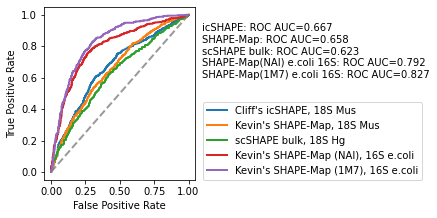

In [61]:
## mus rRNA, icSHAPE
rRNA_icshape_df = load_large_dataFrame("../Data/09.SHAPE_accuracy/busan_dataset_S1_030219/Table_S1_profiles/icSHAPE/Rn18s_icSHAPE.map", sep="\t", header=None, index_col=None)
rRNA_icshape_df.columns = ['Nucleotide','Norm_profile','undef','Sequence']
rRNA_icshape_df = rRNA_icshape_df.set_index('Nucleotide')
rRNA_icshape_df = rRNA_icshape_df.loc[rRNA_icshape_df['Norm_profile']!=-999]
roc_icshape = pd.concat([mus_rRNA_dotbrackets_df[['seq','unpair']], rRNA_icshape_df[['Sequence','Norm_profile']]], axis=1)
roc_icshape = roc_icshape.dropna()
roc_icshape
## mus rRNA, SHAPE-Map
rRNA_Map_df = load_large_dataFrame("../Data/09.SHAPE_accuracy/busan_dataset_S1_030219/Table_S1_profiles/Map/Rn18s_MaP_profile.txt", sep="\t")
rRNA_Map_df
roc_Map = pd.concat([mus_rRNA_dotbrackets_df[['seq','unpair']], rRNA_Map_df[['Sequence','Reactivity_profile', 'Norm_profile']]], axis=1)
roc_Map = roc_Map.dropna()
## hg rRNA, scSHAPE
roc_scshape = pd.concat([rRNA_scSHAPE_df,hg_rRNA_dotbrackets_df],axis=1, join="inner")
#roc_scshape = roc_scshape.loc[~roc_scshape.index.isin(list(range(800,921)))]
roc_scshape = roc_scshape.loc[roc_scshape.index < 1750]

roc_scshape


## E.coli 16S rRNA
ecoli_rRNA_df = load_large_dataFrame("../Data/09.SHAPE_accuracy/busan_dataset_S1_030219/Ecoli_rRNA_profiles/Ecoli_cellfree_16S_NAI_profile.txt", sep="\t")
ecoli_rRNA_df
roc_ecoli = pd.concat([ecoli_bpseq_df[['Sequence.bpseq','unpair']], ecoli_rRNA_df[['Sequence','Reactivity_profile']]], axis=1)
roc_ecoli = roc_ecoli.dropna()
roc_ecoli

ecoli_rRNA_1M7_df = load_large_dataFrame("../Data/09.SHAPE_accuracy/busan_dataset_S1_030219/Ecoli_rRNA_profiles/Ecoli_cellfree_16S_1M7_profile.txt", sep="\t")
ecoli_rRNA_1M7_df
roc_ecoli_1M7 = pd.concat([ecoli_bpseq_df[['Sequence.bpseq','unpair']], ecoli_rRNA_1M7_df[['Sequence','Reactivity_profile']]], axis=1)
roc_ecoli_1M7 = roc_ecoli_1M7.dropna()
roc_ecoli_1M7


# calculate scores
#ns_auc = roc_auc_score(testy, ns_probs)
icshape_auc = roc_auc_score(roc_icshape['unpair'].astype("bool").to_list(), roc_icshape['Norm_profile'].to_list())
map_auc = roc_auc_score(roc_Map['unpair'].astype("bool").to_list(), roc_Map['Norm_profile'].to_list())
scshape_bulk_auc = roc_auc_score(roc_scshape['unpair'].astype("bool").to_list(), roc_scshape['bulk'].to_list())
scshape_pseudobulk_auc = roc_auc_score(roc_scshape['unpair'].astype("bool").to_list(), roc_scshape['single'].to_list())
ecoli_auc = roc_auc_score(roc_ecoli['unpair'].astype("bool").to_list(), roc_ecoli['Reactivity_profile'].to_list())
ecoli_1M7_auc = roc_auc_score(roc_ecoli_1M7['unpair'].astype("bool").to_list(), roc_ecoli_1M7['Reactivity_profile'].to_list())


# summarize scores
#print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('icSHAPE: ROC AUC=%.3f' % (icshape_auc))
print('SHAPE-Map: ROC AUC=%.3f' % (map_auc))
print('scSHAPE bulk: ROC AUC=%.3f' % (scshape_bulk_auc))
print('scSHAPE pseudobulk: ROC AUC=%.3f' % (scshape_pseudobulk_auc))
print('SHAPE-Map(NAI) e.coli 16S: ROC AUC=%.3f' % (ecoli_auc))
print('SHAPE-Map(1M7) e.coli 16S: ROC AUC=%.3f' % (ecoli_1M7_auc))



# calculate roc curves
#ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
icshape_fpr, icshape_tpr, _ = roc_curve(roc_icshape['unpair'].astype("bool").to_list(), roc_icshape['Norm_profile'].to_list())
map_fpr, map_tpr, _ = roc_curve(roc_Map['unpair'].astype("bool").to_list(), roc_Map['Norm_profile'].to_list())
scshape_bulk_fpr, scshape_bulk_tpr, _ = roc_curve(roc_scshape['unpair'].astype("bool").to_list(), roc_scshape['bulk'].to_list())
#scshape_pseudobulk_fpr, scshape_pseudobulk_tpr, _ = roc_curve(roc_scshape['unpair'].astype("bool").to_list(), roc_scshape['single'].to_list())
ecoli_fpr, ecoli_tpr, _ = roc_curve(roc_ecoli['unpair'].astype("bool").to_list(), roc_ecoli['Reactivity_profile'].to_list())
ecoli_1M7_fpr, ecoli_1M7_tpr, _ = roc_curve(roc_ecoli_1M7['unpair'].astype("bool").to_list(), roc_ecoli_1M7['Reactivity_profile'].to_list())



# plot the roc curve for the model
#pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
fig, ax = plt.subplots()
ax.plot(icshape_fpr, icshape_tpr, marker='.', label='Cliff\'s icSHAPE, 18S Mus', linewidth=2, markersize=0, ) #color="blue" 
ax.plot(map_fpr, map_tpr, marker='.', label='Kevin\'s SHAPE-Map, 18S Mus', linewidth=2, markersize=0, ) #
ax.plot(scshape_bulk_fpr, scshape_bulk_tpr, marker='.', label='scSHAPE bulk, 18S Hg', linewidth=2, markersize=0, ) #
#ax.plot(scshape_pseudobulk_fpr, scshape_pseudobulk_tpr, marker='.', label='scSHAPE pseudobulk, 18S Hg', linewidth=2, markersize=0, ) #
ax.plot(ecoli_fpr, ecoli_tpr, marker='.', label='Kevin\'s SHAPE-Map (NAI), 16S e.coli', linewidth=2, markersize=0, ) #
ax.plot(ecoli_1M7_fpr, ecoli_1M7_tpr, marker='.', label='Kevin\'s SHAPE-Map (1M7), 16S e.coli', linewidth=2, markersize=0, ) #


ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="grey", alpha=0.8)

s = "\n".join([
    'icSHAPE: ROC AUC=%.3f' % (icshape_auc),
    'SHAPE-Map: ROC AUC=%.3f' % (map_auc),
    'scSHAPE bulk: ROC AUC=%.3f' % (scshape_bulk_auc),
    
    'SHAPE-Map(NAI) e.coli 16S: ROC AUC=%.3f' % (ecoli_auc),
    'SHAPE-Map(1M7) e.coli 16S: ROC AUC=%.3f' % (ecoli_1M7_auc)]) ##'scSHAPE pseudobulk: ROC AUC=%.3f' % (scshape_pseudobulk_auc),
ax.text(1.1, 0.6, s)
ax.set_position([0.1, 0.15, 0.35, 0.6])
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend(loc=[1.05,0])
# show the plot
pyplot.savefig("../Current_Figures/01. ROC_bulk_with_other_methods/ROC_bulk_with_other_methods.rRNA.pdf")
pyplot.show()

In [62]:
roc_ecoli.to_csv("../Current_Figures/01. ROC_bulk_with_other_methods/Results/Kevin_SHAPE-Map_ecoli_NAI.roc.csv")
roc_ecoli_1M7.to_csv("../Current_Figures/01. ROC_bulk_with_other_methods/Results/Kevin_SHAPE-Map_ecoli_IM7.roc.csv")
roc_Map.to_csv("../Current_Figures/01. ROC_bulk_with_other_methods/Results/Kevin_SHAPE-Map_Mus_SSU_NAI.roc.csv")
roc_icshape.to_csv("../Current_Figures/01. ROC_bulk_with_other_methods/Results/Cliff_icSHAPE_Mus_SSU.roc.csv")
roc_scshape.to_csv("../Current_Figures/01. ROC_bulk_with_other_methods/Results/Yue_scPORT_Hg_SSU.roc.csv")

## 1.3 repeat ROC with DMSO

In [152]:
roc_Map = load_large_dataFrame("../Current_Figures/01. ROC_bulk_with_other_methods/Results/Kevin_SHAPE-Map_Mus_SSU_NAI.roc.csv")
roc_icshape = load_large_dataFrame("../Current_Figures/01. ROC_bulk_with_other_methods/Results/Cliff_icSHAPE_Mus_SSU.roc.csv")
roc_scshape = load_large_dataFrame("../Current_Figures/01. ROC_bulk_with_other_methods/Results/Yue_scPORT_Hg_SSU.roc.csv")
roc_Map = roc_Map.loc[roc_Map.index < 1750]
roc_icshape = roc_icshape.loc[roc_icshape.index < 1750]
roc_icshape = roc_icshape.loc[roc_icshape['Norm_profile']!=-999]
roc_scshape = roc_scshape.loc[roc_scshape.index < 1750]
roc_scshape

,bulk,cell_10,cell_100,single,seq,dotbracket,unpair
Nucleotide,,,,,,,
51,0.024401,0.106917,0.057311,0.111002,U,(,0
52,0.098463,0.030157,-0.051332,0.188043,G,(,0
53,0.111329,0.036154,-0.060585,0.212451,C,(,0
54,0.124270,0.082764,-0.034780,0.197833,A,.,1
55,0.044710,0.189730,0.019300,0.147752,U,.,1
...,...,...,...,...,...,...,...
1745,0.088751,0.174211,-0.021220,0.136218,A,.,1
1746,0.043469,0.038595,-0.043170,0.160082,U,(,0
1747,-0.003581,0.185243,-0.057919,0.047765,C,(,0


,seq,unpair,Sequence,Norm_profile
Nucleotide,,,,
7,U,0,T,0.326371
8,U,1,T,-0.136736
9,G,1,G,4.263296
10,A,1,A,5.384674
11,U,0,T,0.047365
...,...,...,...,...
1695,A,1,A,0.000000
1696,C,0,C,0.000000
1697,A,0,A,0.000000


In [153]:
roc_Map_mutrate = pd.concat([rRNA_Map_df.reset_index().set_index(['Nucleotide','Sequence'])[['Modified_rate','Untreated_rate','Reactivity_profile','Norm_profile']], 
           mus_rRNA_dotbrackets_df.reset_index().set_index(['Nucleotide','seq'])], axis=1)

roc_Map_mutrate = pd.concat([rRNA_Map_df.reset_index().set_index(['Nucleotide','Sequence'])[['Modified_rate','Untreated_rate','Reactivity_profile','Norm_profile']], 
           mus_rRNA_dotbrackets_df.reset_index().set_index(['Nucleotide','seq'])], axis=1)
roc_Map_mutrate = roc_Map_mutrate.reset_index().set_index('Nucleotide')
roc_Map_mutrate = roc_Map_mutrate.dropna()
roc_Map_mutrate = roc_Map_mutrate.loc[roc_Map_mutrate.index < 1750]

In [143]:
roc_Map_mutrate

,level_1,Modified_rate,Untreated_rate,Reactivity_profile,Norm_profile,dotbracket,unpair
Nucleotide,,,,,,,
21,U,0.032424,0.043944,-0.011519,-1.333161,.,1.0
22,A,0.001143,0.000610,0.000533,0.061687,(,0.0
23,G,0.001078,0.002057,-0.000979,-0.113305,(,0.0
24,C,0.001195,0.000719,0.000477,0.055206,.,1.0
25,A,0.002751,0.000397,0.002354,0.272442,(,0.0
...,...,...,...,...,...,...,...
1695,A,0.009017,0.000730,0.008287,0.959103,.,1.0
1696,C,0.018175,0.002498,0.015677,1.814390,),0.0
1697,A,0.001103,0.000748,0.000356,0.041202,),0.0


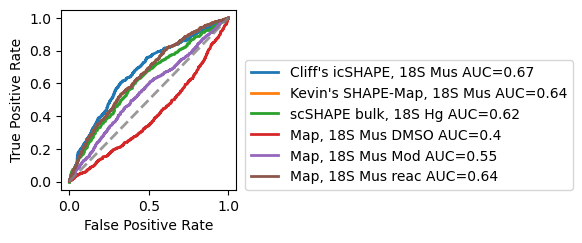

In [154]:
icshape_fpr, icshape_tpr, _ = roc_curve(roc_icshape['unpair'].astype("bool").to_list(), roc_icshape['Norm_profile'].to_list())
map_fpr, map_tpr, _ = roc_curve(roc_Map['unpair'].astype("bool").to_list(), roc_Map['Norm_profile'].to_list())
scshape_bulk_fpr, scshape_bulk_tpr, _ = roc_curve(roc_scshape['unpair'].astype("bool").to_list(), roc_scshape['bulk'].to_list())
map_dmso_fpr, map_dmso_tpr, _ = roc_curve(roc_Map_mutrate['unpair'].astype("bool").to_list(), roc_Map_mutrate['Untreated_rate'].to_list())
map_mod_fpr, map_mod_tpr, _ = roc_curve(roc_Map_mutrate['unpair'].astype("bool").to_list(), roc_Map_mutrate['Modified_rate'].to_list())
map_reac_fpr, map_reac_tpr, _ = roc_curve(roc_Map_mutrate['unpair'].astype("bool").to_list(), roc_Map_mutrate['Reactivity_profile'].to_list())


icshape_auc = roc_auc_score(roc_icshape['unpair'].astype("bool").to_list(), roc_icshape['Norm_profile'].to_list())
map_auc = roc_auc_score(roc_Map['unpair'].astype("bool").to_list(), roc_Map['Norm_profile'].to_list())
scshape_bulk_auc = roc_auc_score(roc_scshape['unpair'].astype("bool").to_list(), roc_scshape['bulk'].to_list())
map_dmso_auc = roc_auc_score(roc_Map_mutrate['unpair'].astype("bool").to_list(), roc_Map_mutrate['Untreated_rate'].to_list())
map_mod_auc = roc_auc_score(roc_Map_mutrate['unpair'].astype("bool").to_list(), roc_Map_mutrate['Modified_rate'].to_list())
map_reac_auc = roc_auc_score(roc_Map_mutrate['unpair'].astype("bool").to_list(), roc_Map_mutrate['Reactivity_profile'].to_list())


fig, ax = plt.subplots(1,1, figsize=(5,3))
ax.plot(icshape_fpr, icshape_tpr, marker='.', label='Cliff\'s icSHAPE, 18S Mus AUC={}'.format(np.round(icshape_auc,2)), linewidth=2, markersize=0, ) #color="blue" 
ax.plot(map_fpr, map_tpr, marker='.', label='Kevin\'s SHAPE-Map, 18S Mus AUC={}'.format(np.round(map_auc,2)), linewidth=2, markersize=0, ) #
ax.plot(scshape_bulk_fpr, scshape_bulk_tpr, marker='.', label='scSHAPE bulk, 18S Hg AUC={}'.format(np.round(scshape_bulk_auc,2)), linewidth=2, markersize=0, ) #
ax.plot(map_dmso_fpr, map_dmso_tpr, marker='.', label='Map, 18S Mus DMSO AUC={}'.format(np.round(map_dmso_auc,2)), linewidth=2, markersize=0, ) #
ax.plot(map_mod_fpr, map_mod_tpr, marker='.', label='Map, 18S Mus Mod AUC={}'.format(np.round(map_mod_auc,2)), linewidth=2, markersize=0, ) #
ax.plot(map_reac_fpr, map_reac_tpr, marker='.', label='Map, 18S Mus reac AUC={}'.format(np.round(map_reac_auc,2)), linewidth=2, markersize=0, ) #

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="grey", alpha=0.8)
#ax.text(1.1, 0.6, s)
ax.set_position([0.1, 0.15, 0.35, 0.6])
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend(loc=[1.05,0])
#plt.savefig("../Current_Figures/")
plt.show()

## 1.4 hg rRNA from Cliff's icSHAPE

In [93]:
current_18s = load_large_dataFrame("../../../../FigureFactory/rRNA_ROC/human_18S.txt", sep="\t", header=None, index_col=None)
current_18s.columns = ['Nucleotide','nt','solvent_accessibility']
current_18s= current_18s.set_index('Nucleotide')
current_18s

,nt,solvent_accessibility
Nucleotide,,
1,U,0.000000
2,A,0.000000
3,C,0.000000
4,C,0.000000
5,U,0.000000
...,...,...
1865,C,0.000000
1866,A,0.000000
1867,U,0.000000


In [94]:
with open("../Data/09.SHAPE_accuracy/calcSHAPE.g2t.RTBD.rRNA.txt") as f:
    o_concat_lst = []
    for l in f:
        i = l.strip("\n").split("\t")
        n = 0
        concat_lst = []
        for ii in i:
            if n == 0:
                gene = ii
            elif n == 1:
                print (ii)
                gene_len = int(ii)
            elif ii == "NULL":
                iii = [np.nan]*7
                concat_lst.append(iii)
            else:
                iii = ii.split(",")
                concat_lst.append(iii)
            n += 1
        rRNA_df = pd.DataFrame(concat_lst)
        rRNA_df.index = pd.MultiIndex.from_tuples(list(zip([gene]*rRNA_df.index.size,range(1, gene_len+1))), names=['gene','pos'])
        o_concat_lst.append(rRNA_df)
    
rRNA_df = pd.concat(o_concat_lst)
rRNA_df.columns =['nt', 'N.RT','N.BD','D.RT','D.BD','shape','shapeNum']
rRNA_df[['N.RT','N.BD','D.RT','D.BD']] = rRNA_df[['N.RT','N.BD','D.RT','D.BD']].astype(np.float64)
rRNA_df['N.rt_pct'] = rRNA_df['N.RT']/rRNA_df['N.BD']
rRNA_df['D.rt_pct'] = rRNA_df['D.RT']/rRNA_df['D.BD']
rRNA_df['reac'] = rRNA_df['N.rt_pct'] - (0.25*rRNA_df['D.rt_pct'])
rRNA_df = rRNA_df.loc[(rRNA_df['N.BD']>=1000)&(rRNA_df['D.BD']>=1000)]
rRNA_df

1869
5070


nt    N.RT     N.BD   D.RT    D.BD      shape shapeNum  \
gene           pos                                                           
human-4V6X-18S 6     G  4652.0  30344.0  243.0  5093.0          0        2   
               7     G  1759.0  34996.0   64.0  5336.0  0.0117213        2   
               8     T   624.0  36755.0   21.0  5400.0  0.0055983        2   
               9     T   303.0  37379.0   29.0  5421.0          0        2   
               10    G   272.0  37682.0   20.0  5450.0          0        2   
...                 ..     ...      ...    ...     ...        ...      ...   
human-4V6X-28S 5061  A     0.0  11045.0    0.0  1789.0          0        2   
               5062  G     0.0  10806.0    0.0  1758.0          0        2   
               5063  G     0.0  10318.0    0.0  1701.0          0        2   
               5064  G     0.0   8591.0    0.0  1530.0          0        2   
               5065  T     0.0   2880.0    0.0  1036.0          0        2   

                     N.rt_pct  D.rt_pct      reac  
gene           pos                                 
human-4V6X-18S 6     0.153309  0.047713  0.141381  
               7     0.050263  0.011994  0.047264  
               8     0.016977  0.003889  0.016005  
               9     0.008106  0.005350  0.006769  
               10    0.007218  0.003670  0.006301  
...                       ...       ...       ...  
human-4V6X-28S 5061  0.000000  0.000000  0.000000  
               5062  0.000000  0.000000  0.000000  
               5063  0.000000  0.000000  0.000000  
               5064  0.000000  0.000000  0.000000  
               5065  0.000000  0.000000  0.000000  

[4844 rows x 10 columns]

## 2. human ribosonmal RNAs filtered by solvernt accessibility

In [145]:
current_18s = load_large_dataFrame("../../../../FigureFactory/rRNA_ROC/human_18S.txt", sep="\t", header=None, index_col=None)
current_18s.columns = ['Nucleotide','nt','solvent_accessibility']
current_18s= current_18s.set_index('Nucleotide')
current_18s

,nt,solvent_accessibility
Nucleotide,,
1,U,0.000000
2,A,0.000000
3,C,0.000000
4,C,0.000000
5,U,0.000000
...,...,...
1865,C,0.000000
1866,A,0.000000
1867,U,0.000000


In [114]:
with open("../Data/09.SHAPE_accuracy/calcSHAPE.g2t.RTBD.rRNA.txt") as f:
    o_concat_lst = []
    for l in f:
        i = l.strip("\n").split("\t")
        n = 0
        concat_lst = []
        for ii in i:
            if n == 0:
                gene = ii
            elif n == 1:
                print (ii)
                gene_len = int(ii)
            elif ii == "NULL":
                iii = [np.nan]*7
                concat_lst.append(iii)
            else:
                iii = ii.split(",")
                concat_lst.append(iii)
            n += 1
        rRNA_df = pd.DataFrame(concat_lst)
        rRNA_df.index = pd.MultiIndex.from_tuples(list(zip([gene]*rRNA_df.index.size,range(1, gene_len+1))), names=['gene','pos'])
        o_concat_lst.append(rRNA_df)
    
rRNA_df = pd.concat(o_concat_lst)
rRNA_df.columns =['nt', 'N.RT','N.BD','D.RT','D.BD','shape','shapeNum']
rRNA_df[['N.RT','N.BD','D.RT','D.BD']] = rRNA_df[['N.RT','N.BD','D.RT','D.BD']].astype(np.float64)
rRNA_df['N.rt_pct'] = rRNA_df['N.RT']/rRNA_df['N.BD']
rRNA_df['D.rt_pct'] = rRNA_df['D.RT']/rRNA_df['D.BD']
rRNA_df['reac'] = rRNA_df['N.rt_pct'] - (0.25*rRNA_df['D.rt_pct'])
rRNA_df = rRNA_df.loc[(rRNA_df['N.BD']>=2000)&(rRNA_df['D.BD']>=2000)]
rRNA_df = rRNA_df.loc[rRNA_df.index.get_level_values('gene')=="human-4V6X-18S"]
rRNA_df = rRNA_df.loc[rRNA_df.index.get_level_values('pos').isin(list(range(50,1650)))]
rRNA_df['shape'] = rRNA_df['shape'].astype(np.float64)
rRNA_df['shape'] = rRNA_df['shape']*-1
rRNA_df

1869
5070


nt    N.RT      N.BD   D.RT    D.BD     shape shapeNum  \
gene           pos                                                           
human-4V6X-18S 50    A  2372.0   85603.0   21.0  9297.0 -0.041687       10   
               51    T   937.0   87879.0    5.0  9310.0 -0.018320       11   
               52    G   197.0   88785.0    1.0  9312.0 -0.003881       11   
               53    C    93.0   88829.0   27.0  9297.0 -0.000000       11   
               54    A  1906.0   88252.0   18.0  9312.0 -0.032712       11   
...                 ..     ...       ...    ...     ...       ...      ...   
               1645  C  6879.0  193348.0  167.0  8039.0 -0.534641       40   
               1646  C  4111.0  199538.0   91.0  8198.0 -0.323734       40   
               1647  A  5145.0  202658.0  104.0  8274.0 -0.405951       40   
               1648  G   553.0  206823.0   73.0  8363.0 -0.015255       40   
               1649  T   546.0  202734.0   83.0  8276.0 -0.010390       40   

                     N.rt_pct  D.rt_pct      reac  
gene           pos                                 
human-4V6X-18S 50    0.027709  0.002259  0.027145  
               51    0.010662  0.000537  0.010528  
               52    0.002219  0.000107  0.002192  
               53    0.001047  0.002904  0.000321  
               54    0.021597  0.001933  0.021114  
...                       ...       ...       ...  
               1645  0.035578  0.020774  0.030385  
               1646  0.020603  0.011100  0.017828  
               1647  0.025388  0.012569  0.022245  
               1648  0.002674  0.008729  0.000492  
               1649  0.002693  0.010029  0.000186  

[1158 rows x 10 columns]

0.5926428257199701
0.47842985842985847
0.41539974283337117


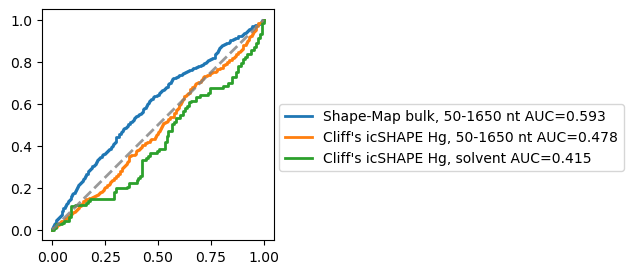

In [116]:
fig, ax = plt.subplots(figsize=(3,3))

reac2db_df = pd.concat([rRNA_scSHAPE_df, current_18s[['solvent_accessibility']], hg_rRNA_dotbrackets_df], axis=1, join="outer")
#icshape_auc = reac2db_df.loc[reac2db_df['solvent_accessibility']>=3].dropna()
icshape_auc = reac2db_df.dropna()
icshape_fpr, icshape_tpr, _ = roc_curve(icshape_auc['unpair'].astype("bool").to_list(), icshape_auc['bulk'].to_list())
icshape_auc = roc_auc_score(icshape_auc['unpair'].astype("bool").to_list(), icshape_auc['bulk'].to_list())


print (icshape_auc)
ax.plot(icshape_fpr, icshape_tpr, marker='.', label='Shape-Map bulk, 50-1650 nt AUC={}'.format(np.round(icshape_auc,3)), linewidth=2, markersize=0, ) #color="blreac

reac2db_df = pd.concat([rRNA_df.xs("human-4V6X-18S"), current_18s[['solvent_accessibility']], hg_rRNA_dotbrackets_df], axis=1, join="outer")
#icshape_auc = reac2db_df.loc[reac2db_df['solvent_accessibility']>=3].dropna()
icshape_auc = reac2db_df.dropna()
icshape_fpr, icshape_tpr, _ = roc_curve(icshape_auc['unpair'].astype("bool").to_list(), icshape_auc['reac'].to_list())
icshape_auc = roc_auc_score(icshape_auc['unpair'].astype("bool").to_list(), icshape_auc['reac'].to_list())
print (icshape_auc)
ax.plot(icshape_fpr, icshape_tpr, marker='.', label='Cliff\'s icSHAPE Hg, 50-1650 nt AUC={}'.format(np.round(icshape_auc,3)), linewidth=2, markersize=0, ) #color="blue" 

reac2db_df = pd.concat([rRNA_df.xs("human-4V6X-18S"), current_18s[['solvent_accessibility']], hg_rRNA_dotbrackets_df], axis=1, join="outer")
icshape_auc = reac2db_df.loc[reac2db_df['solvent_accessibility']>=3].dropna()
#icshape_auc = reac2db_df.dropna()
icshape_fpr, icshape_tpr, _ = roc_curve(icshape_auc['unpair'].astype("bool").to_list(), icshape_auc['reac'].to_list())
icshape_auc = roc_auc_score(icshape_auc['unpair'].astype("bool").to_list(), icshape_auc['reac'].to_list())
print (icshape_auc)
ax.plot(icshape_fpr, icshape_tpr, marker='.', label='Cliff\'s icSHAPE Hg, solvent AUC={}'.format(np.round(icshape_auc,3)), linewidth=2, markersize=0, ) #color="blue" 

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="grey", alpha=0.8)
plt.legend(loc=[1.02,0.3])
plt.show()

In [189]:


with open("../Data/09.SHAPE_accuracy/icSHAPE_cliff/calcSHAPE.rRNA.shape") as f:
    for l in f:
        i = l.strip("\n").split("\t")
        if i[0] != "human-4V6X-18S":
            continue
        
        n = 0 
        concat_lst = []
        for ii in i:
            if n == 0:
                gene = ii
            elif n == 1:
                gene_len = int(ii)
            elif n == 2:
                pass
            elif ii == "NULL":
                concat_lst.append(np.nan)
            else:
                concat_lst.append(np.float64(ii))
            n += 1
rRNA_icSHAPE_df = pd.DataFrame(concat_lst)
#rRNA_icSHAPE_df.index = list(range(1, gene_len+1))
rRNA_icSHAPE_df.columns = ['shape.reac']
rRNA_icSHAPE_df.dropna()

reac2db_df = pd.concat([rRNA_icSHAPE_df, current_18s[['solvent_accessibility']], hg_rRNA_dotbrackets_df], axis=1, join="inner")
reac2db_df.to_csv("../Data/09.SHAPE_accuracy/icSHAPE_cliff/rRNA_reac_to_structure.csv")
reac2db_df = reac2db_df.dropna()
reac2db_df = reac2db_df.loc[reac2db_df.index.isin(list(range(50,1801)))]

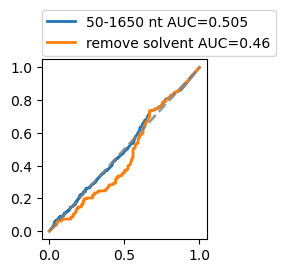

In [196]:
fig, ax = plt.subplots(figsize=(3,3))

## full length
icshape_fpr, icshape_tpr, _ = roc_curve(reac2db_df['unpair'].astype("bool").to_list(), reac2db_df['shape.reac'].to_list())
icshape_auc = roc_auc_score(reac2db_df['unpair'].astype("bool").to_list(), reac2db_df['shape.reac'].to_list())
ax.plot(icshape_fpr, icshape_tpr, marker='.', label='50-1650 nt AUC={}'.format(np.round(icshape_auc,3)), linewidth=2, markersize=0, ) #color="blue" 

## solvent accessibility
local_reac2db_df = reac2db_df.loc[reac2db_df['solvent_accessibility']>=3]
icshape_fpr, icshape_tpr, _ = roc_curve(local_reac2db_df['unpair'].astype("bool").to_list(), local_reac2db_df['shape.reac'].to_list())
icshape_auc = roc_auc_score(local_reac2db_df['unpair'].astype("bool").to_list(), local_reac2db_df['shape.reac'].to_list())
ax.plot(icshape_fpr, icshape_tpr, marker='.', label='remove solvent AUC={}'.format(np.round(icshape_auc,3)), linewidth=2, markersize=0, ) #color="blue" 

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="grey", alpha=0.8)
plt.legend(loc=[0,1.02])
ax.set_position([0.1, 0.15, 0.55, 0.6])
plt.savefig("../Data/09.SHAPE_accuracy/icSHAPE_cliff/rRNA_reac_to_structure.pdf")
plt.show()

0.6168579775704457
0.46683960002188485
0.6523824389136419
0.42906635349383443
0.5232719806125832
0.48291250733998825


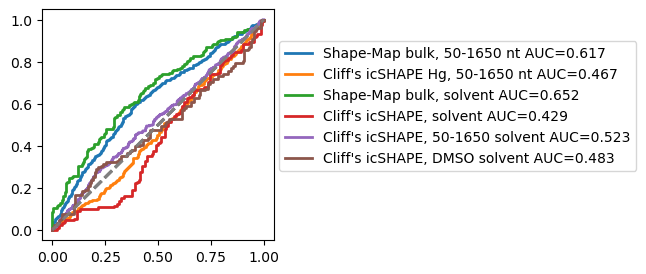

In [42]:
fig, ax = plt.subplots(figsize=(3,3))

reac2db_df = pd.concat([rRNA_scSHAPE_df, current_18s[['solvent_accessibility']], hg_rRNA_dotbrackets_df], axis=1, join="outer")
#icshape_auc = reac2db_df.loc[reac2db_df['solvent_accessibility']>=3].dropna()
icshape_auc = reac2db_df.loc[list(range(50,1650))].dropna()
icshape_fpr, icshape_tpr, _ = roc_curve(icshape_auc['unpair'].astype("bool").to_list(), icshape_auc['bulk'].to_list())
icshape_auc = roc_auc_score(icshape_auc['unpair'].astype("bool").to_list(), icshape_auc['bulk'].to_list())
print (icshape_auc)
ax.plot(icshape_fpr, icshape_tpr, marker='.', label='Shape-Map bulk, 50-1650 nt AUC={}'.format(np.round(icshape_auc,3)), linewidth=2, markersize=0, ) #color="blue" 
ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="grey", alpha=0.8)

reac2db_df = pd.concat([rRNA_df.xs("human-4V6X-18S"), current_18s[['solvent_accessibility']], hg_rRNA_dotbrackets_df], axis=1, join="outer")
#icshape_auc = reac2db_df.loc[reac2db_df['solvent_accessibility']>=3].dropna()
icshape_auc = reac2db_df.loc[list(range(50,1650))].dropna()
icshape_fpr, icshape_tpr, _ = roc_curve(icshape_auc['unpair'].astype("bool").to_list(), icshape_auc['reac'].to_list())
icshape_auc = roc_auc_score(icshape_auc['unpair'].astype("bool").to_list(), icshape_auc['reac'].to_list())
print (icshape_auc)
ax.plot(icshape_fpr, icshape_tpr, marker='.', label='Cliff\'s icSHAPE Hg, 50-1650 nt AUC={}'.format(np.round(icshape_auc,3)), linewidth=2, markersize=0, ) #color="blue" 
ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="grey", alpha=0.8)

reac2db_df = pd.concat([rRNA_scSHAPE_df, current_18s[['solvent_accessibility']], hg_rRNA_dotbrackets_df], axis=1, join="outer")
icshape_auc = reac2db_df.loc[reac2db_df['solvent_accessibility']>=3].dropna()
#icshape_auc = reac2db_df.loc[list(range(50,1650))].dropna()
icshape_fpr, icshape_tpr, _ = roc_curve(icshape_auc['unpair'].astype("bool").to_list(), icshape_auc['bulk'].to_list())
icshape_auc = roc_auc_score(icshape_auc['unpair'].astype("bool").to_list(), icshape_auc['bulk'].to_list())
print (icshape_auc)
ax.plot(icshape_fpr, icshape_tpr, marker='.', label='Shape-Map bulk, solvent AUC={}'.format(np.round(icshape_auc,3)), linewidth=2, markersize=0, ) #color="blue" 
ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="grey", alpha=0.8)

reac2db_df = pd.concat([rRNA_df.xs("human-4V6X-18S"), current_18s[['solvent_accessibility']], hg_rRNA_dotbrackets_df], axis=1, join="outer")
icshape_auc = reac2db_df.loc[reac2db_df['solvent_accessibility']>=3].dropna()
#icshape_auc = reac2db_df.loc[list(range(50,1650))].dropna()
icshape_fpr, icshape_tpr, _ = roc_curve(icshape_auc['unpair'].astype("bool").to_list(), icshape_auc['reac'].to_list())
icshape_auc = roc_auc_score(icshape_auc['unpair'].astype("bool").to_list(), icshape_auc['reac'].to_list())
print (icshape_auc)
ax.plot(icshape_fpr, icshape_tpr, marker='.', label='Cliff\'s icSHAPE, solvent AUC={}'.format(np.round(icshape_auc,3)), linewidth=2, markersize=0, ) #color="blue" 
ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="grey", alpha=0.8)

## DMSO
#reac2db_df = pd.concat([rRNA_df.xs("human-4V6X-18S"), current_18s[['solvent_accessibility']], hg_rRNA_dotbrackets_df], axis=1, join="outer")
#icshape_auc = reac2db_df.loc[reac2db_df['solvent_accessibility']>=3].dropna()
icshape_auc = reac2db_df.loc[list(range(50,1650))].dropna()
icshape_fpr, icshape_tpr, _ = roc_curve(icshape_auc['unpair'].astype("bool").to_list(), icshape_auc['D.rt_pct'].to_list())
icshape_auc = roc_auc_score(icshape_auc['unpair'].astype("bool").to_list(), icshape_auc['D.rt_pct'].to_list())
print (icshape_auc)
ax.plot(icshape_fpr, icshape_tpr, marker='.', label='Cliff\'s icSHAPE, 50-1650 solvent AUC={}'.format(np.round(icshape_auc,3)), linewidth=2, markersize=0, ) #color="blue" 
ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="grey", alpha=0.8)

icshape_auc = reac2db_df.loc[reac2db_df['solvent_accessibility']>=3].dropna()
#icshape_auc = reac2db_df.loc[list(range(50,1650))].dropna()
icshape_fpr, icshape_tpr, _ = roc_curve(icshape_auc['unpair'].astype("bool").to_list(), icshape_auc['D.rt_pct'].to_list())
icshape_auc = roc_auc_score(icshape_auc['unpair'].astype("bool").to_list(), icshape_auc['D.rt_pct'].to_list())
print (icshape_auc)
ax.plot(icshape_fpr, icshape_tpr, marker='.', label='Cliff\'s icSHAPE, DMSO solvent AUC={}'.format(np.round(icshape_auc,3)), linewidth=2, markersize=0, ) #color="blue" 
ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="grey", alpha=0.8)

plt.legend(loc=[1.02,0.3])
plt.show()

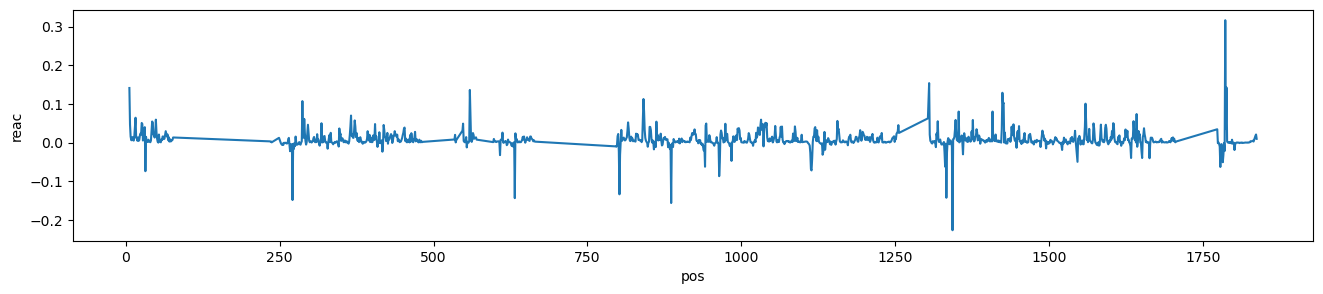

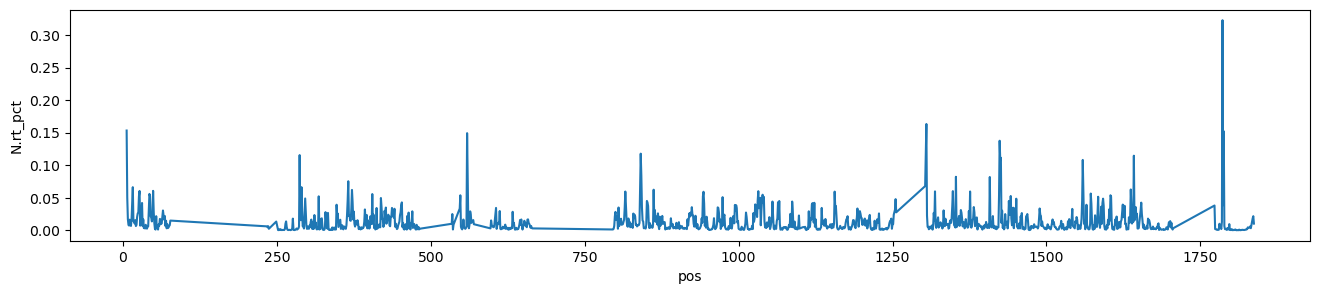

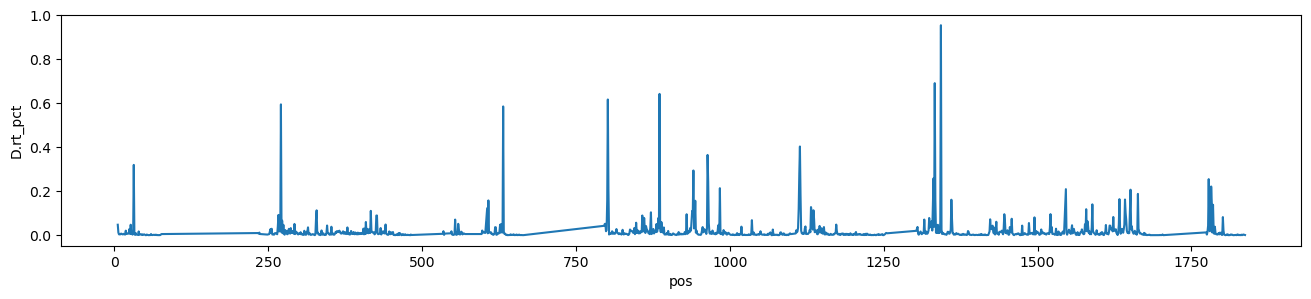

In [41]:
fig, ax = plt.subplots(1,1, figsize=(16,3))
sns.lineplot(data=rRNA_df.loc['human-4V6X-18S'].reset_index(), x="pos", y="reac", ax=ax)
plt.show()

fig, ax = plt.subplots(1,1, figsize=(16,3))
sns.lineplot(data=rRNA_df.loc['human-4V6X-18S'].reset_index(), x="pos", y="N.rt_pct", ax=ax)
plt.show()

fig, ax = plt.subplots(1,1, figsize=(16,3))
sns.lineplot(data=rRNA_df.loc['human-4V6X-18S'].reset_index(), x="pos", y="D.rt_pct", ax=ax)
plt.show()

## Cliff's Data

### From Sun Lei

In [3]:
current_18s = load_large_dataFrame("../../../../FigureFactory/rRNA_ROC/human_18S.txt", sep="\t", header=None, index_col=None)
current_18s.columns = ['Nucleotide','nt','solvent_accessibility']
current_18s= current_18s.set_index('Nucleotide')
current_18s

,nt,solvent_accessibility
Nucleotide,,
1,U,0.000000
2,A,0.000000
3,C,0.000000
4,C,0.000000
5,U,0.000000
...,...,...
1865,C,0.000000
1866,A,0.000000
1867,U,0.000000


In [132]:
with open("../Data/09.SHAPE_accuracy/icSHAPE_cliff/calcSHAPE.rRNA.shape") as f:
    for l in f:
        i = l.strip("\n").split("\t")
        if i[0] != "human-4V6X-18S":
            continue
            
        n = 0 
        concat_lst = []
        for ii in i:
            if n == 0:
                gene = ii
            elif n == 1:
                gene_len = int(ii)
            elif n == 2:
                pass
            elif ii == "NULL":
                concat_lst.append(np.nan)
            else:
                concat_lst.append(np.float64(ii))
            n += 1
rRNA_icSHAPE_df_zy = pd.DataFrame(concat_lst)
#rRNA_icSHAPE_df.index = list(range(1, gene_len+1))
rRNA_icSHAPE_df_zy.columns = ['zy.shape.reac']
#rRNA_icSHAPE_df_zy.dropna()
rRNA_scSHAPE_df

lib_type,bulk,cell_10,cell_100,single
Nucleotide,,,,
50,0.056519,0.152039,0.148830,0.095469
51,0.019903,0.255790,0.095329,0.077594
52,-0.003219,-0.087079,-0.072226,0.159943
53,0.278705,-0.078240,-0.177099,0.326592
54,0.058500,0.273780,0.067569,0.150819
...,...,...,...,...
1816,0.810034,0.519025,-0.137523,0.267059
1817,0.102454,0.349584,0.217944,0.225078
1818,0.463505,0.536730,0.038626,0.316558


In [136]:
with open("../Data/09.SHAPE_accuracy/icSHAPE_cliff/Data_from_SunLei/human_small_sl.shape") as f:
    for l in f:
        i = l.strip("\n").split("\t")
        
        n = 0 
        concat_lst = []
        for ii in i:
            if n == 0:
                gene = ii
            elif n == 1:
                gene_len = int(ii)
            elif n == 2:
                pass
            elif ii == "NULL":
                concat_lst.append(np.nan)
            else:
                concat_lst.append(np.float64(ii))
            n += 1
rRNA_icSHAPE_df_sl = pd.DataFrame(concat_lst)
#rRNA_icSHAPE_df.index = list(range(1, gene_len+1))
rRNA_icSHAPE_df_sl.columns = ['sl.shape.reac']
rRNA_icSHAPE_df_sl.dropna()

,sl.shape.reac
5,0.036
6,0.003
7,0.026
8,0.219
9,0.557
...,...
1835,0.122
1836,0.996
1837,0.384
1838,0.404


In [145]:
with open("../Data/09.SHAPE_accuracy/human_18S.dot") as f:
    for l in f:
        if l[0] == ">":
            name = l[1:].strip("\n")
        elif l[0] in ['A','T','C','G','U']:
            seq = list(l.strip("\n"))
        elif l[0] in ['.','(',')',"<",">"]:
            dotbrackets = list(l.strip("\n"))
hg_rRNA_dotbrackets_df = pd.DataFrame([seq, dotbrackets]).T
hg_rRNA_dotbrackets_df.columns = ['seq','dotbracket']
hg_rRNA_dotbrackets_df['Nucleotide'] = list(range(1, hg_rRNA_dotbrackets_df.index.size+1))
hg_rRNA_dotbrackets_df['unpair'] = 0
hg_rRNA_dotbrackets_df.loc[hg_rRNA_dotbrackets_df['dotbracket']==".", 'unpair'] = 1
hg_rRNA_dotbrackets_df = hg_rRNA_dotbrackets_df.set_index('Nucleotide')
hg_rRNA_dotbrackets_df

,seq,dotbracket,unpair
Nucleotide,,,
1,U,.,1
2,A,.,1
3,C,.,1
4,C,(,0
5,U,(,0
...,...,...,...
1865,C,.,1
1866,A,.,1
1867,U,.,1


In [200]:
with open("../Data/09.SHAPE_accuracy/icSHAPE_cliff/Data_from_SunLei/human_small.dot") as f:
    n = 0
    for l in f:
        print (n)
        print (l)
        if n == 1:
            seqs = l.strip("\n").split()
        elif n == 2:
            
        n += 1

0
>human_small

1
UACCUGGUUGAUCCUGCCAGUAGCAUAUGCUUGUCUCAAAGAUUAAGCCAUGCAUGUCUAAGUACGCACGGCCGGUACAGUGAAACUGCGAAUGGCUCAUUAAAUCAGUUAUGGUUCCUUUGGUCGCUCGCUCCUCUCCUACUUGGAUAACUGUGGUAAUUCUAGAGCUAAUACAUGCCGACGGGCGCUGACCCCCUUCGCGGGGGGGAUGCGUGCAUUUAUCAGAUCAAAACCAACCCGGUCAGCCCCUCUCCGGCCCCGGCCGGGGGGCGGGCGCCGGCGGCUUUGGUGACUCUAGAUAACCUCGGGCCGAUCGCACGCCCCCCGUGGCGGCGACGACCCAUUCGAACGUCUGCCCUAUCAACUUUCGAUGGUAGUCGCCGUGCCUACCAUGGUGACCACGGGUGACGGGGAAUCAGGGUUCGAUUCCGGAGAGGGAGCCUGAGAAACGGCUACCACAUCCAAGGAAGGCAGCAGGCGCGCAAAUUACCCACUCCCGACCCGGGGAGGUAGUGACGAAAAAUAACAAUACAGGACUCUUUCGAGGCCCUGUAAUUGGAAUGAGUCCACUUUAAAUCCUUUAACGAGGAUCCAUUGGAGGGCAAGUCUGGUGCCAGCAGCCGCGGUAAUUCCAGCUCCAAUAGCGUAUAUUAAAGUUGCUGCAGUUAAAAAGCUCGUAGUUGGAUCUUGGGAGCGGGCGGGCGGUCCGCCGCGAGGCGAGCCACCGCCCGUCCCCGCCCCUUGCCUCUCGGCGCCCCCUCGAUGCUCUUAGCUGAGUGUCCCGCGGGGCCCGAAGCGUUUACUUUGAAAAAAUUAGAGUGUUCAAAGCAGGCCCGAGCCGCCUGGAUACCGCAGCUAGGAAUAAUGGAAUAGGACCGCGGUUCUAUUUUGUUGGUUUUCGGAACUGAGGCCAUGAUUAAGAGGGACGGCCGGGGGCAUUCGUAUUGCGCCGCUAGAGGUGAAAUUCCUUGGACCGGCGCAA

In [201]:
with open("../Data/09.SHAPE_accuracy/icSHAPE_cliff/human_18S.dot") as f:
    n = 0
    for l in f:
        print (n)
        print (l)

0
>human-4V6X-18S

0
UACCUGGUUGAUCCUGCCAGUAGCAUAUGCUUGUCUCAAAGAUUAAGCCAUGCAUGUCUAAGUACGCACGGCCGGUACAGUGAAACUGCGAAUGGCUCAUUAAAUCAGUUAUGGUUCCUUUGGUCGCUCGCUCCUCUCCUACUUGGAUAACUGUGGUAAUUCUAGAGCUAAUACAUGCCGACGGGCGCUGACCCCCUUCGCGGGGGGGAUGCGUGCAUUUAUCAGAUCAAAACCAACCCGGUCAGCCCCUCUCCGGCCCCGGCCGGGGGGCGGGCGCCGGCGGCUUUGGUGACUCUAGAUAACCUCGGGCCGAUCGCACGCCCCCCGUGGCGGCGACGACCCAUUCGAACGUCUGCCCUAUCAACUUUCGAUGGUAGUCGCCGUGCCUACCAUGGUGACCACGGGUGACGGGGAAUCAGGGUUCGAUUCCGGAGAGGGAGCCUGAGAAACGGCUACCACAUCCAAGGAAGGCAGCAGGCGCGCAAAUUACCCACUCCCGACCCGGGGAGGUAGUGACGAAAAAUAACAAUACAGGACUCUUUCGAGGCCCUGUAAUUGGAAUGAGUCCACUUUAAAUCCUUUAACGAGGAUCCAUUGGAGGGCAAGUCUGGUGCCAGCAGCCGCGGUAAUUCCAGCUCCAAUAGCGUAUAUUAAAGUUGCUGCAGUUAAAAAGCUCGUAGUUGGAUCUUGGGAGCGGGCGGGCGGUCCGCCGCGAGGCGAGCCACCGCCCGUCCCCGCCCCUUGCCUCUCGGCGCCCCCUCGAUGCUCUUAGCUGAGUGUCCCGCGGGGCCCGAAGCGUUUACUUUGAAAAAAUUAGAGUGUUCAAAGCAGGCCCGAGCCGCCUGGAUACCGCAGCUAGGAAUAAUGGAAUAGGACCGCGGUUCUAUUUUGUUGGUUUUCGGAACUGAGGCCAUGAUUAAGAGGGACGGCCGGGGGCAUUCGUAUUGCGCCGCUAGAGGUGAAAUUCUUGGACCGGCGC

### From Pan Li

In [3]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt

def calc_AUC(dot, shape_list):
    """
    dot                 -- Dotbracket structure
    shape_list          -- A list of SHAPE scores
    
    Calculate the AUC between structure and shape
    
    Return [point1, point2, point3,...]
    """
    from sklearn.metrics import roc_curve, auc, roc_auc_score
    import numpy as np
    
    dot_array = np.array(list(dot))
    shape_array = np.array(shape_list, dtype=str)
    
    dot_array = dot_array[shape_array!='NULL']
    shape_array = shape_array[shape_array!='NULL']
    shape_array = shape_array.astype(float)
    
    unpaired = (dot_array=='.')
    
    FPR, TPR, _ = roc_curve(unpaired, shape_array)
    auc_1 = auc(FPR, TPR)
    auc_2 = roc_auc_score(unpaired, shape_array)
    print(auc_1, auc_2)
    
    return auc_1


489
0.8129012345679012 0.8129012345679012
auc: 0.8129012345679012
0.69336860670194 0.69336860670194
0.69336860670194
0.6538095238095237 0.6538095238095237
0.6538095238095237


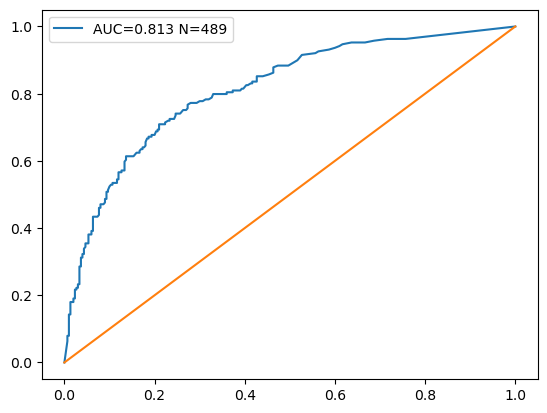

In [259]:
#######################################
### Human 18S data
#######################################

human_18S_seq = 'UACCUGGUUGAUCCUGCCAGUAGCAUAUGCUUGUCUCAAAGAUUAAGCCAUGCAUGUCUAAGUACGCACGGCCGGUACAGUGAAACUGCGAAUGGCUCAUUAAAUCAGUUAUGGUUCCUUUGGUCGCUCGCUCCUCUCCUACUUGGAUAACUGUGGUAAUUCUAGAGCUAAUACAUGCCGACGGGCGCUGACCCCCUUCGCGGGGGGGAUGCGUGCAUUUAUCAGAUCAAAACCAACCCGGUCAGCCCCUCUCCGGCCCCGGCCGGGGGGCGGGCGCCGGCGGCUUUGGUGACUCUAGAUAACCUCGGGCCGAUCGCACGCCCCCCGUGGCGGCGACGACCCAUUCGAACGUCUGCCCUAUCAACUUUCGAUGGUAGUCGCCGUGCCUACCAUGGUGACCACGGGUGACGGGGAAUCAGGGUUCGAUUCCGGAGAGGGAGCCUGAGAAACGGCUACCACAUCCAAGGAAGGCAGCAGGCGCGCAAAUUACCCACUCCCGACCCGGGGAGGUAGUGACGAAAAAUAACAAUACAGGACUCUUUCGAGGCCCUGUAAUUGGAAUGAGUCCACUUUAAAUCCUUUAACGAGGAUCCAUUGGAGGGCAAGUCUGGUGCCAGCAGCCGCGGUAAUUCCAGCUCCAAUAGCGUAUAUUAAAGUUGCUGCAGUUAAAAAGCUCGUAGUUGGAUCUUGGGAGCGGGCGGGCGGUCCGCCGCGAGGCGAGCCACCGCCCGUCCCCGCCCCUUGCCUCUCGGCGCCCCCUCGAUGCUCUUAGCUGAGUGUCCCGCGGGGCCCGAAGCGUUUACUUUGAAAAAAUUAGAGUGUUCAAAGCAGGCCCGAGCCGCCUGGAUACCGCAGCUAGGAAUAAUGGAAUAGGACCGCGGUUCUAUUUUGUUGGUUUUCGGAACUGAGGCCAUGAUUAAGAGGGACGGCCGGGGGCAUUCGUAUUGCGCCGCUAGAGGUGAAAUUCCUUGGACCGGCGCAAGACGGACCAGAGCGAAAGCAUUUGCCAAGAAUGUUUUCAUUAAUCAAGAACGAAAGUCGGAGGUUCGAAGACGAUCAGAUACCGUCGUAGUUCCGACCAUAAACGAUGCCGACCGGCGAUGCGGCGGCGUUAUUCCCAUGACCCGCCGGGCAGCUUCCGGGAAACCAAAGUCUUUGGGUUCCGGGGGGAGUAUGGUUGCAAAGCUGAAACUUAAAGGAAUUGACGGAAGGGCACCACCAGGAGUGGAGCCUGCGGCUUAAUUUGACUCAACACGGGAAACCUCACCCGGCCCGGACACGGACAGGAUUGACAGAUUGAUAGCUCUUUCUCGAUUCCGUGGGUGGUGGUGCAUGGCCGUUCUUAGUUGGUGGAGCGAUUUGUCUGGUUAAUUCCGAUAACGAACGAGACUCUGGCAUGCUAACUAGUUACGCGACCCCCGAGCGGUCGGCGUCCCCCAACUUCUUAGAGGGACAAGUGGCGUUCAGCCACCCGAGAUUGAGCAAUAACAGGUCUGUGAUGCCCUUAGAUGUCCGGGGCUGCACGCGCGCUACACUGACUGGCUCAGCGUGUGCCUACCCUACGCCGGCAGGCGCGGGUAACCCGUUGAACCCCAUUCGUGAUGGGGAUCGGGGAUUGCAAUUAUUCCCCAUGAACGAGGAAUUCCCAGUAAGUGCGGGUCAUAAGCUUGCGUUGAUUAAGUCCCUGCCCUUUGUACACACCGCCCGUCGCUACUACCGAUUGGAUGGUUUAGUGAGGCCCUCGGAUCGGCCCCGCCGGGGUCGGCCCACGGCCCUGGCGGAGCGCUGAGAAGACGGUCGAACUUGACUAUCUAGAGGAAGUAAAAGUCGUAACAAGGUUUCCGUAGGUGAACCUGCGGAAGGAUCAUUA'
# 18S Reference structure
human_18S_dot = '...(((((...<<<.))))).((.(((((((..(.((..((.....(((.(((..((...(((....((..........))...)))))......(((.......(((...(..((....(((..................(.((.....((.(((.....))).))......)).).......((((...((((((....))))))...))))....(((((........(((((.((((...((((.((((((((....))))))))..)))).)))).....))))).......)))))...........((((.((((......))))))))....)))...)))...))).(((....(((....(((((((.........))))))))))......)))...((((((((....))))...))))))).((.(((..........))).)).(.((....)).)...)))))).).....(.(((...(((((...))))).)))).)...)).).....(((((((((.(((....)))..)))))).)))......((..(...........)..)).........((((((<<<....((((.....((.>>>)).......)))))))))).))))))).))..........(.(<<.....(.((...(((.......(((.(((((((((((((.((((....))))....))))))))..)))))))).......((((.(((((...(((((((......)))))))....)))))))))................................................................................................................................((((((..(...((((..((..((((((((...(((......))).......))))))))..)).......((....))...))))..)..)).))))...)))...)).)....((((((....(...((((.........))))...).))))))..........((((((.(((..(.((((((.(((((....))))))))))).)..)))...((..>>))...)))....))).).)..(((.....((((....))))....)))...>>>..(((((.(((((((..((..((((((.(((.((((((....((((........))))........(((((.(....(((((........((.(((........))).))......)))))...((.((((..((((((((....(((.(((((....)))...(((......)))...)).))).....(.((.(.(.((((..((((....(((..((((....)))).)))....))))..))))).)..(..(((((.....)))))..)....)).)....))).)))...).))))))).....).)))))...)).)))).))).)...((.(((......(((.......((..((((....))))..)).....)))......))).))......(.....(((((..........))))).....).....))))).....((((((((.......))))))))......))...)))))))))).))....(..((.(..((((.((..(.((((((((.(((..((((.((...(((((.((((((((((((.....))))))))))))...)))))...)).))))..))).)))))))))..)).))))...).))...)....((((((((((....))))))))))........'
# 18S accessibility from PDB(6ek0)
human_18S_acc = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.55, 0.0, 0.0, 0.0, 0.0, 1.22, 0.0, 0.0, 28.48, 13.71, 6.37, 50.84, 26.24, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.1, 56.09, 13.34, 52.37, 0.0, 71.04, 51.03, 52.46, 0.0, 0.0, 0.0, 52.44, 46.09, 65.94, 6.21, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.14, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.62, 0.0, 0.0, 0.0, 1.6, 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 16.18, 0.0, 0.0, 8.67, 0.0, 5.38, 9.9, 6.26, 29.1, 1.89, 0.0, 0.0, 0.0, 5.9, 0.0, 0.0, 0.0, 0.0, 0.0, 13.15, 2.53, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.29, 29.94, 14.54, 19.29, 0.0, 2.01, 9.35, 0.0, 0.0, 0.0, 72.33, 18.4, 54.15, 0.57, 0.0, 0.0, 12.14, 0.0, 76.17, 57.36, 20.43, 19.36, 3.91, 65.2, 0.69, 0.0, 0.0, 67.8, 14.57, 63.68, 0.0, 32.18, 56.31, 60.13, 53.23, 0.62, 70.59, 62.05, 57.17, 18.31, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 39.39, 42.01, 0.0, 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 0.0, 0.0, 0.0, 9.49, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.17, 34.71, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.32, 18.73, 0.0, 1.13, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.28, 85.92, 4.82, 36.11, 20.49, 8.28, 0.0, 0.0, 99.86, 0.0, 41.22, 0.0, 47.39, 33.21, 33.58, 24.27, 58.45, 39.87, 0.0, 0.0, 0.0, 3.71, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.63, 0.0, 0.0, 0.0, 1.72, 0.69, 7.43, 13.32, 0.0, 0.0, 0.0, 0.0, 0.0, 1.15, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.53, 0.0, 0.0, 0.0, 0.0, 18.09, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.77, 0.0, 0.58, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.98, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.76, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.25, 17.14, 0.63, 0.0, 1.19, 11.02, 0.0, 0.0, 3.07, 0.0, 0.0, 0.0, 4.63, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.27, 31.9, 57.85, 12.85, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 47.8, 0.58, 0.0, 0.0, 0.0, 15.65, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.89, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.29, 34.59, 8.53, 0.0, 0.0, 0.0, 0.58, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.28, 43.72, 24.22, 49.1, 25.01, 38.4, 21.94, 0.0, 20.25, 87.97, 0.0, 11.48, 13.75, 27.8, 39.72, 60.03, 13.48, 52.86, 0.0, 0.0, 71.49, 48.94, 30.34, 0.0, 0.0, 20.67, 53.6, 0.0, 13.48, 80.73, 0.0, 0.0, 0.0, 18.9, 0.0, 0.0, 0.0, 0.69, 45.27, 81.35, 18.51, 101.78, 51.13, 0.0, 0.0, 0.0, 0.0, 0.0, 55.3, 57.12, 17.95, 0.0, 2.4, 0.0, 0.0, 4.05, 72.77, 65.83, 63.31, 2.91, 0.0, 0.0, 0.0, 0.0, 25.44, 0.0, 6.78, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.33, 8.83, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.85, 51.59, 24.04, 0.0, 0.0, 0.0, 9.79, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.29, 0.0, 0.0, 0.0, 31.49, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.39, 36.79, 4.26, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.58, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.71, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.65, 21.95, 0.0, 86.46, 54.81, 0.0, 37.57, 0.0, 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 0.0, 40.26, 0.0, 44.66, 0.0, 6.28, 8.55, 33.29, 0.0, 86.85, 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 0.0, 0.0, 16.88, 46.17, 2.91, 0.0, 53.27, 85.97, 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 3.99, 37.52, 6.65, 82.07, 84.11, 0.0, 0.0, 1.39, 26.03, 26.95, 1.15, 0.0, 0.0, 0.56, 0.0, 2.75, 0.0, 0.0, 0.0, 7.73, 26.98, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.93, 1.14, 0.0, 0.0, 0.0, 0.0, 0.69, 9.03, 0.0, 0.0, 0.0, 0.0, 0.0, 12.41, 0.0, 0.0, 0.0, 0.0, 8.94, 48.22, 0.0, 87.7, 0.0, 1.15, 0.0, 0.0, 0.0, 27.99, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 40.65, 0.0, 0.57, 0.0, 0.0, 0.0, 0.0, 0.0, 24.96, 42.61, 0.0, 0.0, 0.0, 0.0, 0.0, 16.09, 0.0, 1.24, 0.0, 0.0, 4.07, 0.0, 0.0, 0.0, 0.0, 0.0, 32.28, 62.55, 42.81, 49.17, 76.01, 50.88, 67.59, 58.66, 19.48, 12.22, 72.41, 0.0, 0.0, 7.14, 53.26, 27.24, 64.57, 65.84, 73.09, 57.21, 0.0, 84.84, 3.48, 39.38, 4.86, 5.85, 0.6, 8.92, 13.53, 35.75, 11.57, 51.87, 66.73, 32.07, 54.48, 10.0, 0.0, 0.63, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.24, 0.0, 0.0, 0.0, 9.45, 0.62, 8.6, 1.13, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 40.21, 30.17, 58.19, 40.1, 0.0, 0.0, 0.0, 0.0, 15.81, 0.0, 0.0, 0.0, 0.0, 0.0, 8.5, 0.0, 13.98, 0.0, 0.0, 0.0, 'NULL', 0.0, 0.0, 37.31, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.34, 43.22, 1.19, 3.64, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.85, 29.34, 35.11, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.13, 5.37, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.86, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.39, 0.0, 0.0, 0.0, 10.31, 2.93, 16.91, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.02, 0.0, 0.0, 0.0, 0.0, 0.0, 18.85, 0.0, 0.0, 0.0, 0.0, 0.0, 8.75, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.05, 39.54, 2.35, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.44, 27.72, 14.5, 0.0, 18.77, 0.0, 0.0, 0.0, 0.0, 30.8, 41.36, 0.0, 16.99, 24.27, 0.0, 0.0, 0.0, 0.0, 0.57, 11.77, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.11, 45.61, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.37, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.56, 5.29, 0.0, 1.82, 0.0, 0.0, 0.0, 20.08, 3.12, 0.57, 1.76, 1.14, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.62, 0.0, 0.0, 4.31, 0.0, 0.0, 0.0, 0.0, 0.58, 0.0, 1.22, 2.63, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.19, 0.0, 0.0, 2.57, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.46, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.17, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.81, 0.0, 0.0, 0.0, 76.83, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.49, 49.76, 48.89, 53.65, 57.01, 4.54, 0.0, 0.0, 0.62, 0.0, 0.0, 0.0, 2.33, 18.09, 0.0, 3.79, 0.0, 45.75, 50.22, 2.99, 0.0, 0.0, 0.0, 3.04, 0.0, 0.0, 0.0, 10.62, 46.82, 50.56, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 49.96, 50.98, 64.67, 58.39, 7.35, 0.0, 0.0, 0.0, 0.0, 0.0, 8.47, 46.36, 0.0, 0.0, 1.15, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.51, 0.0, 15.58, 0.0, 0.0, 0.0, 0.0, 0.0, 5.25, 43.0, 0.0, 0.0, 0.57, 58.46, 0.62, 0.0, 0.0, 0.0, 0.0, 14.4, 0.62, 0.0, 0.0, 0.0, 59.65, 24.22, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.96, 0.0, 1.78, 0.0, 0.0, 24.09, 33.67, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.41, 9.94, 0.0, 0.0, 0.56, 0.0, 0.0, 0.0, 0.0, 0.0, 17.1, 11.25, 36.16, 61.63, 27.31, 0.0, 0.0, 0.0, 5.21, 0.0, 0.0, 0.0, 0.0, 5.12, 3.48, 4.59, 0.0, 0.0, 0.0, 0.0, 2.42, 41.2, 19.39, 0.0, 1.77, 56.49, 0.0, 0.0, 0.0, 28.07, 29.75, 5.9, 0.0, 0.0, 0.0, 0.0, 0.0, 3.09, 0.0, 43.81, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.31, 51.39, 47.82, 47.92, 0.0, 0.0, 5.42, 0.0, 0.0, 0.0, 21.39, 38.95, 44.97, 28.18, 32.15, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.1, 14.98, 0.0, 0.0, 0.0, 0.62, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.43, 16.44, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.81, 0.0, 32.92, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.69, 27.86, 59.18, 63.78, 3.8, 0.0, 0.0, 0.0, 0.0, 39.02, 61.76, 56.35, 33.51, 10.53, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.95, 0.0, 0.0, 0.0, 0.0, 2.85, 0.0, 0.0, 0.0, 0.0, 0.0, 2.97, 0.0, 25.45, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.46, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.55, 0.0, 18.52, 0.0, 0.0, 0.0, 0.0, 5.46, 28.7, 61.0, 16.3, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.69, 0.0, 5.75, 0.57, 0.0, 0.0, 0.0, 0.0, 0.63, 0.58, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.23, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.58, 8.75, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.54, 0.0, 3.89, 30.12, 57.55, 33.83, 0.0, 11.26, 21.14, 0.0, 0.0, 31.61, 16.7, 3.01, 0.0, 0.0, 0.0, 0.0, 0.0, 2.86, 28.35, 24.52, 0.0, 11.03, 0.0, 0.58, 6.87, 4.56, 44.31, 20.03, 21.86, 0.0, 0.0, 82.19, 0.0, 54.43, 0.0, 0.0, 0.0, 4.43, 0.0, 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 53.69, 45.96, 0.0, 13.84, 0.0, 15.57, 24.65, 36.09, 14.82, 16.99, 0.0, 5.7, 0.0, 38.89, 0.0, 22.23, 22.16, 36.5, 0.57, 0.0, 0.0, 1.14, 0.0, 3.39, 0.69, 3.49, 0.0, 0.0, 0.0, 0.0, 0.0, 15.76, 43.48, 5.24, 0.0, 0.0, 33.76, 0.0, 0.0, 23.77, 31.15, 44.69, 55.13, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6, 21.89, 81.31, 0.0, 0.0, 0.0, 0.0, 28.83, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.91, 0.0, 0.0, 0.0, 4.81, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.15, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.58]
human_18S_seq = list(human_18S_seq)
human_18S_dot = list(human_18S_dot)


del human_18S_seq[968]
del human_18S_dot[968]
del human_18S_acc[968]



# icSHAPE scores of 18S rRNA
human_18S_icshape = ['NULL', 'NULL', 'NULL', 'NULL', 'NULL', 0.036, 0.003, 0.026, 0.219, 0.557, 1.0, 0.194, 0.169, 0.0, 0.21, 0.0, 0.0, 0.192, 0.373, 0.0, 0.912, 0.927, 0.0, 0.396, 0.429, 0.66, 0.0, 0.101, 0.01, 0.0, 0.0, 0.056, 0.023, 0.0, 0.0, 0.022, 0.287, 0.645, 0.632, 0.285, 0.172, 0.163, 0.267, 0.608, 0.416, 0.149, 0.017, 0.0, 0.273, 0.054, 0.056, 0.009, 0.093, 0.073, 0.14, 0.149, 0.088, 0.098, 0.203, 0.316, 0.194, 0.154, 0.197, 0.061, 0.164, 0.017, 0.064, 0.017, 0.019, 0.068, 0.024, 0.057, 0.894, 1.0, 0.972, 0.546, 0.233, 0.35, 0.307, 0.081, 0.203, 0.434, 0.64, 0.557, 0.159, 0.091, 0.183, 0.055, 0.456, 0.207, 0.599, 0.08, 0.054, 0.053, 0.05, 0.32, 0.081, 0.618, 0.001, 0.888, 0.827, 0.877, 1.0, 0.442, 0.019, 0.175, 0.215, 0.293, 0.088, 0.776, 0.372, 0.228, 0.438, 0.046, 0.348, 0.0, 0.065, 0.114, 0.141, 0.125, 0.027, 0.316, 0.191, 0.108, 0.107, 0.188, 0.137, 0.075, 0.085, 0.029, 0.468, 0.192, 0.275, 0.571, 0.12, 0.825, 0.382, 0.233, 1.0, 0.41, 0.137, 1.0, 0.126, 0.058, 0.014, 0.141, 0.126, 0.341, 0.493, 0.263, 0.226, 0.36, 0.034, 0.034, 0.017, 0.074, 0.08, 0.314, 0.328, 0.233, 0.103, 0.067, 0.034, 0.01, 0.929, 1.0, 0.048, 0.238, 0.356, 0.585, 0.239, 0.445, 0.082, 0.773, 0.055, 0.108, 0.042, 0.01, 0.058, 0.624, 0.256, 0.307, 0.477, 0.853, 0.015, 0.0, 0.003, 0.01, 0.018, 0.067, 0.01, 0.008, 0.0, 0.0, 0.003, 0.066, 0.227, 0.449, 0.94, 0.294, 0.013, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.029, 0.011, 0.013, 0.003, 0.009, 0.0, 0.0, 0.369, 0.223, 0.089, 0.089, 0.337, 0.498, 0.433, 0.206, 0.746, 0.989, 1.0, 0.792, 0.501, 0.861, 0.128, 0.106, 0.184, 0.059, 0.031, 0.349, 0.317, 0.228, 0.164, 0.002, 0.0, 0.0, 0.085, 0.216, 0.895, 0.47, 0.008, 0.001, 0.0, 0.0, 0.003, 0.0, 0.007, 0.012, 0.0, 0.0, 0.0, 0.0, 0.005, 0.03, 0.388, 0.578, 0.184, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.38, 0.004, 0.0, 0.0, 0.0, 0.014, 0.0, 0.0, 0.0, 0.001, 0.073, 1.0, 0.391, 0.299, 1.0, 0.619, 0.095, 0.001, 0.041, 0.483, 1.0, 0.654, 0.128, 0.032, 0.091, 0.042, 0.003, 0.095, 0.108, 0.306, 0.401, 0.061, 0.018, 0.195, 0.047, 0.606, 0.127, 0.163, 0.0, 0.0, 0.025, 0.021, 0.944, 0.012, 0.027, 0.01, 0.443, 0.529, 0.159, 0.009, 0.01, 0.01, 0.0, 0.0, 0.282, 0.522, 0.045, 0.741, 0.035, 0.006, 0.0, 0.0, 0.0, 0.0, 0.046, 0.007, 0.041, 0.083, 0.004, 0.0, 0.0, 0.879, 0.6, 0.683, 0.129, 0.214, 0.328, 0.011, 0.03, 0.003, 0.109, 0.043, 0.005, 0.034, 0.0, 0.0, 0.0, 0.004, 0.344, 0.817, 1.0, 0.318, 0.387, 0.242, 0.225, 0.621, 1.0, 0.922, 0.303, 0.572, 0.167, 0.094, 0.274, 0.0, 0.152, 0.329, 0.169, 0.023, 0.053, 0.0, 0.0, 0.01, 0.0, 0.0, 0.005, 0.064, 0.177, 0.616, 0.31, 0.112, 0.423, 0.02, 0.281, 0.073, 0.009, 0.028, 0.442, 0.389, 0.235, 1.0, 0.288, 0.543, 0.055, 0.0, 0.0, 0.0, 0.837, 0.0, 0.0, 0.0, 0.157, 0.0, 0.0, 1.0, 0.858, 0.378, 0.358, 0.118, 0.178, 0.839, 0.014, 0.249, 0.255, 0.377, 0.578, 0.678, 0.599, 0.0, 0.117, 0.413, 0.523, 0.933, 0.652, 0.667, 0.396, 0.362, 0.089, 0.246, 0.135, 0.025, 0.017, 0.008, 0.121, 0.303, 0.472, 0.62, 0.853, 0.868, 0.12, 0.295, 0.047, 0.013, 0.091, 0.192, 0.052, 0.013, 0.474, 0.066, 0.609, 0.275, 0.065, 0.02, 0.209, 0.287, 0.708, 0.066, 0.164, 0.168, 0.096, 0.034, 0.007, 0.167, 0.031, 0.021, 0.106, 0.029, 0.042, 0.053, 0.269, 0.101, 0.428, 0.264, 0.811, 0.614, 0.882, 0.711, 0.661, 0.795, 0.148, 0.12, 0.098, 0.306, 0.173, 0.083, 0.062, 0.032, 0.011, 0.026, 0.228, 0.429, 0.639, 0.315, 0.245, 1.0, 0.036, 0.0, 0.172, 0.096, 0.0, 1.0, 0.925, 0.0, 0.095, 0.675, 0.652, 0.099, 0.0, 0.233, 0.419, 0.362, 0.339, 0.478, 0.524, 0.661, 0.468, 0.129, 0.195, 0.113, 0.147, 0.356, 0.016, 0.099, 0.012, 0.0, 0.017, 0.022, 0.022, 0.057, 0.053, 0.373, 1.0, 0.458, 0.732, 0.073, 0.031, 0.023, 0.054, 0.222, 0.0, 0.008, 0.022, 0.01, 0.06, 1.0, 0.989, 0.095, 0.039, 0.125, 0.407, 0.332, 0.178, 0.205, 0.244, 0.283, 0.174, 0.074, 0.294, 0.559, 0.083, 0.178, 0.498, 0.169, 0.732, 0.962, 0.786, 0.012, 0.06, 0.037, 0.105, 0.137, 0.209, 0.606, 0.83, 0.2, 0.22, 0.276, 0.041, 0.077, 0.087, 0.0, 0.126, 0.087, 0.506, 0.262, 0.173, 0.206, 0.174, 0.232, 0.255, 0.305, 0.634, 0.033, 0.0, 0.353, 0.406, 0.432, 0.838, 0.084, 0.041, 0.144, 0.129, 0.314, 0.19, 0.0, 0.042, 0.53, 0.089, 0.244, 0.124, 0.085, 0.017, 0.021, 0.0, 0.0, 0.001, 0.088, 0.0, 0.622, 0.209, 0.259, 0.083, 0.018, 0.057, 0.111, 0.02, 0.062, 0.036, 0.113, 0.213, 0.421, 0.216, 0.371, 0.157, 0.0, 0.12, 0.155, 0.287, 0.188, 0.19, 0.128, 0.079, 0.313, 0.318, 0.224, 0.186, 0.118, 0.056, 0.116, 0.06, 0.061, 0.208, 0.131, 0.249, 0.368, 0.215, 0.274, 0.449, 0.015, 0.498, 0.544, 0.378, 0.297, 0.056, 0.136, 0.065, 0.194, 0.369, 0.319, 0.248, 0.264, 0.021, 0.001, 0.013, 0.322, 0.404, 0.125, 0.97, 0.979, 1.0, 0.123, 0.038, 0.064, 1.0, 0.035, 0.013, 0.001, 0.023, 0.017, 0.003, 0.002, 0.0, 0.015, 0.02, 0.002, 0.009, 0.025, 0.008, 0.03, 0.001, 0.0, 0.016, 0.101, 0.755, 0.96, 0.27, 0.047, 0.006, 0.011, 0.006, 0.217, 0.134, 0.147, 0.99, 0.027, 0.005, 0.0, 0.004, 0.0, 0.0, 0.0, 0.099, 0.058, 0.068, 0.093, 0.023, 0.231, 0.007, 0.0, 0.0, 0.0, 0.02, 0.349, 0.848, 0.361, 0.375, 0.166, 0.091, 0.749, 0.05, 0.005, 0.006, 0.012, 0.487, 0.008, 0.0, 0.0, 0.001, 0.0, 0.013, 0.017, 0.022, 0.054, 0.01, 0.013, 0.014, 0.01, 0.027, 0.089, 0.142, 0.801, 1.0, 1.0, 1.0, 0.319, 0.015, 0.021, 0.012, 0.009, 0.023, 0.004, 0.0, 0.018, 0.108, 0.202, 0.499, 0.019, 0.002, 0.0, 0.0, 0.0, 0.0, 0.0, 0.065, 0.403, 0.542, 0.0, 0.0, 0.0, 0.006, 0.375, 0.055, 0.107, 0.112, 0.119, 0.056, 0.04, 0.147, 0.138, 0.183, 0.394, 0.751, 0.567, 0.237, 0.069, 0.014, 0.256, 0.148, 0.186, 0.065, 0.078, 0.041, 0.1, 0.045, 0.402, 0.299, 0.377, 0.343, 0.11, 0.131, 0.087, 0.063, 0.082, 0.0, 0.034, 0.8, 1.0, 1.0, 0.544, 0.197, 0.039, 0.011, 0.003, 0.0, 0.006, 0.064, 0.894, 0.915, 0.776, 0.231, 0.035, 0.205, 0.024, 0.003, 0.093, 0.021, 0.043, 1.0, 0.373, 0.575, 0.203, 0.511, 0.355, 0.205, 0.622, 0.164, 0.0, 0.354, 0.174, 0.392, 0.329, 0.597, 0.332, 0.434, 0.404, 0.421, 0.009, 0.116, 0.013, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.278, 0.123, 0.124, 0.057, 0.057, 0.079, 0.134, 0.064, 0.004, 0.336, 0.008, 0.096, 0.175, 0.381, 0.049, 0.214, 0.175, 0.124, 0.148, 0.058, 0.07, 0.054, 0.117, 0.065, 0.056, 0.05, 0.025, 0.376, 0.196, 0.463, 0.792, 0.643, 0.819, 0.654, 1.0, 0.791, 0.798, 0.296, 0.248, 0.365, 0.669, 0.467, 0.157, 0.524, 0.032, 0.008, 0.006, 0.027, 0.003, 0.012, 0.22, 0.0, 1.0, 1.0, 0.532, 0.133, 0.206, 0.086, 0.576, 0.391, 0.059, 0.049, 0.002, 0.003, 0.0, 0.0, 0.0, 0.002, 0.053, 0.184, 0.6, 0.033, 0.004, 0.0, 0.0, 0.0, 0.586, 0.707, 0.019, 0.601, 0.245, 0.367, 0.002, 0.046, 0.047, 0.899, 0.233, 0.644, 0.719, 0.134, 0.04, 0.0, 0.0, 0.0, 0.0, 0.0, 0.036, 0.074, 0.436, 0.057, 0.05, 0.002, 0.35, 0.369, 0.045, 0.674, 0.581, 0.728, 0.603, 0.113, 0.209, 0.001, 0.001, 0.002, 0.0, 0.0, 0.05, 0.013, 0.03, 0.002, 0.0, 0.058, 0.147, 0.295, 0.31, 0.151, 0.011, 0.0, 0.0, 0.0, 0.0, 0.0, 0.027, 0.058, 0.001, 0.267, 0.124, 0.178, 0.41, 0.406, 0.329, 0.17, 0.382, 0.535, 0.424, 0.774, 0.581, 0.0, 0.412, 0.793, 0.795, 0.786, 0.863, 0.246, 0.057, 0.057, 0.013, 0.114, 0.004, 0.055, 0.094, 0.013, 0.0, 0.012, 0.145, 0.239, 0.62, 0.27, 0.043, 0.0, 0.056, 0.04, 0.0, 0.109, 0.282, 0.982, 0.601, 1.0, 0.319, 0.023, 0.058, 0.0, 0.002, 0.067, 0.166, 0.15, 0.154, 0.119, 0.174, 0.046, 0.014, 0.019, 0.118, 0.1, 0.009, 0.72, 0.487, 0.14, 1.0, 0.939, 0.143, 0.277, 0.547, 0.058, 0.14, 0.102, 0.042, 0.06, 0.323, 0.997, 0.086, 0.12, 0.083, 0.0, 0.0, 0.908, 0.186, 1.0, 0.213, 0.226, 0.027, 0.002, 0.012, 0.011, 0.0, 0.219, 0.0, 0.08, 0.353, 0.336, 0.868, 0.912, 0.633, 0.216, 0.871, 0.128, 0.458, 0.109, 0.028, 0.008, 0.0, 0.009, 0.014, 0.0, 0.0, 0.034, 0.64, 0.002, 0.148, 0.161, 0.111, 0.097, 0.333, 0.167, 0.08, 0.0, 0.083, 0.0, 0.022, 0.068, 0.06, 0.097, 0.003, 0.109, 0.0, 0.057, 0.192, 0.877, 0.782, 0.801, 0.425, 0.104, 0.041, 0.022, 0.019, 0.029, 0.168, 0.091, 0.091, 0.056, 0.045, 0.069, 0.032, 0.007, 0.0, 0.093, 0.368, 0.474, 0.591, 0.13, 0.007, 0.077, 0.025, 0.0, 0.009, 0.113, 0.182, 0.425, 0.381, 0.223, 0.011, 0.028, 0.236, 0.39, 0.717, 0.419, 0.085, 0.205, 0.649, 0.59, 0.524, 0.458, 0.21, 0.543, 0.262, 0.741, 0.626, 0.288, 0.56, 0.691, 0.105, 0.238, 0.704, 0.726, 0.891, 0.309, 0.072, 0.005, 0.0, 0.041, 0.046, 0.018, 0.354, 0.119, 0.0, 0.209, 0.618, 0.591, 0.424, 0.716, 0.038, 0.032, 0.017, 0.027, 0.075, 0.01, 0.0, 0.018, 0.048, 0.061, 0.036, 0.012, 0.0, 0.013, 0.04, 0.13, 0.231, 0.296, 0.246, 0.076, 0.03, 0.103, 0.083, 0.273, 0.9, 0.507, 0.841, 0.525, 1.0, 0.292, 0.004, 0.087, 0.252, 0.218, 0.74, 0.916, 0.242, 0.153, 0.395, 0.166, 0.703, 0.302, 0.168, 0.075, 0.29, 0.748, 0.537, 0.131, 0.0, 0.023, 0.103, 0.167, 0.173, 0.976, 0.03, 0.012, 0.122, 0.36, 0.127, 0.719, 0.111, 0.071, 0.155, 0.074, 0.0, 0.195, 0.538, 0.038, 0.147, 0.037, 0.06, 0.01, 0.025, 0.351, 1.0, 0.911, 1.0, 0.479, 0.114, 0.09, 0.012, 0.021, 0.129, 0.063, 0.032, 0.141, 0.008, 0.072, 0.614, 0.4, 1.0, 0.335, 0.1, 0.299, 0.419, 0.49, 0.119, 0.187, 0.285, 0.399, 0.23, 0.161, 0.0, 0.152, 0.013, 0.01, 0.11, 0.313, 0.187, 0.15, 0.135, 0.165, 0.01, 0.0, 0.0, 0.067, 0.116, 0.168, 0.405, 0.689, 0.309, 0.107, 0.072, 0.044, 0.862, 0.014, 0.026, 0.107, 0.237, 0.289, 0.001, 0.0, 0.048, 0.351, 0.21, 0.074, 0.194, 0.205, 0.029, 0.008, 0.229, 0.053, 0.036, 0.019, 0.075, 0.633, 0.212, 0.953, 0.13, 0.031, 0.05, 0.309, 0.364, 0.727, 0.583, 0.133, 0.205, 0.435, 0.161, 0.0, 0.093, 0.2, 0.142, 0.166, 0.121, 0.129, 0.041, 0.0, 0.059, 0.133, 0.049, 0.113, 0.086, 0.19, 0.056, 0.041, 0.062, 0.108, 0.035, 0.47, 0.106, 0.091, 0.04, 0.103, 0.218, 0.037, 0.022, 0.018, 0.014, 0.047, 0.006, 0.002, 0.0, 0.0, 0.303, 1.0, 1.0, 1.0, 0.006, 0.327, 0.009, 0.003, 0.0, 0.0, 0.087, 0.055, 0.077, 0.158, 0.029, 0.113, 0.569, 0.322, 0.334, 0.698, 0.27, 0.107, 0.051, 0.068, 0.0, 0.395, 0.515, 0.212, 0.761, 0.069, 0.066, 0.035, 0.0, 0.117, 0.0, 0.008, 0.387, 0.695, 0.046, 0.035, 0.087, 0.001, 0.001, 0.043, 0.557, 0.65, 0.707, 0.482, 0.03, 0.002, 0.079, 0.012, 0.0, 0.114, 0.183, 0.081, 0.011, 0.247, 0.147, 0.147, 0.156, 0.165, 0.143, 0.0, 0.038, 0.653, 1.0, 1.0, 0.969, 0.321, 0.636, 0.394, 0.0, 0.195, 0.061, 0.0, 0.142, 0.0, 0.064, 0.559, 0.232, 0.363, 0.198, 0.0, 0.0, 0.215, 0.636, 0.939, 0.605, 0.752, 0.405, 0.294, 0.285, 0.146, 0.034, 0.0, 0.006, 0.0, 0.0, 0.13, 0.077, 0.726, 0.101, 0.343, 0.455, 0.137, 0.0, 0.0, 0.048, 0.148, 0.039, 0.023, 0.462, 0.166, 0.616, 0.174, 0.114, 0.402, 0.591, 0.904, 0.203, 0.077, 0.0, 0.0, 0.315, 0.303, 0.498, 0.309, 0.0, 0.096, 0.007, 0.115, 0.0, 0.0, 0.291, 0.815, 1.0, 1.0, 0.16, 0.288, 0.024, 0.139, 0.758, 0.147, 0.061, 0.032, 0.0, 0.0, 0.17, 1.0, 0.802, 0.29, 0.017, 0.0, 0.002, 0.0, 0.014, 0.02, 0.0, 0.0, 0.387, 0.838, 0.226, 0.132, 0.022, 0.115, 0.041, 0.06, 0.623, 0.792, 0.623, 0.113, 0.005, 0.0, 0.0, 0.109, 0.03, 0.224, 0.133, 0.56, 0.283, 0.991, 0.998, 0.292, 0.044, 0.022, 0.041, 0.0, 0.024, 0.378, 0.176, 0.487, 0.046, 0.11, 0.0, 0.143, 0.042, 0.032, 0.202, 0.29, 0.294, 0.761, 0.383, 0.412, 0.745, 0.188, 0.216, 0.015, 0.0, 0.0, 0.0, 0.307, 0.23, 0.423, 0.985, 0.788, 0.202, 0.295, 0.158, 1.0, 0.076, 0.285, 0.709, 0.442, 0.551, 0.026, 0.014, 0.0, 0.0, 0.344, 0.498, 0.721, 0.574, 0.378, 0.075, 0.226, 0.019, 0.021, 0.025, 0.003, 0.0, 0.0, 0.358, 0.362, 0.378, 0.261, 0.071, 0.029, 0.044, 0.061, 0.068, 0.029, 0.012, 0.048, 0.031, 0.043, 0.105, 0.103, 0.238, 0.31, 0.011, 0.117, 0.079, 0.027, 0.021, 0.029, 0.032, 0.045, 0.013, 0.011, 0.012, 0.037, 0.106, 0.096, 0.022, 0.182, 0.328, 0.154, 0.342, 0.105, 0.28, 0.081, 0.035, 0.174, 0.183, 0.485, 0.04, 0.15, 0.223, 0.055, 0.381, 0.496, 0.989, 0.832, 0.152, 0.243, 0.695, 0.349, 0.027, 0.068, 1.0, 1.0, 0.674, 0.548, 0.043, 0.021, 0.0, 0.001, 0.006, 0.017, 0.047, 0.143, 0.053, 0.034, 0.012, 0.019, 0.055, 0.012, 0.005, 0.007, 0.003, 0.001, 0.237, 0.006, 0.001, 0.001, 0.101, 0.128, 0.006, 0.005, 0.001, 0.0, 0.0, 0.002, 0.0, 0.002, 0.006, 0.0, 0.0, 0.0, 0.002, 0.001, 0.0, 0.022, 0.001, 0.038, 0.438, 0.838, 1.0, 1.0, 0.404, 0.015, 0.016, 0.002, 0.001, 0.0, 0.003, 0.004, 0.004, 0.0, 0.0, 0.01, 0.059, 1.0, 0.455, 0.909, 0.061, 0.1, 0.099, 0.103, 0.02, 0.133, 0.166, 0.123, 0.31, 0.001, 0.03, 0.049, 0.001, 0.0, 0.0, 0.036, 0.102, 0.028, 0.141, 0.005, 0.0, 0.036, 0.007, 0.003, 0.043, 0.0, 0.0, 0.014, 0.051, 0.126, 0.131, 0.089, 0.024, 0.018, 0.107, 0.038, 0.042, 0.173, 0.548, 0.373, 0.273, 0.284, 0.184, 0.066, 0.26, 0.299, 0.851, 0.971, 0.276, 0.419, 1.0, 0.122, 0.996, 0.384, 0.404, 0.17, 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL']
del human_18S_icshape[968]

#######################################
### Calculate AUC score and Visualization
#######################################

assert len(human_18S_seq) == len(human_18S_dot) == len(human_18S_acc) == len(human_18S_icshape)

filter_str = ""
base_shape = []
i = 1
temp_out = []
for base, base_str,acc,shape in zip(human_18S_seq, human_18S_dot, human_18S_acc, human_18S_icshape):
    if shape!='NULL':
        if (acc=='NULL' or acc>3) and (i<800 or i>920):
            filter_str += base_str
            base_shape.append(float(shape))
            temp_out.append([i, base, base_str, acc, shape])
        else:
            temp_out.append([i, base, base_str, acc, shape])
    else:
        temp_out.append([i, base, base_str, acc, shape])
    i += 1

N = len(filter_str)
print (N)
auc = calc_AUC(filter_str, base_shape)

print( "auc:", auc )
print( calc_AUC("."+filter_str[:-1], base_shape) )
print( calc_AUC(filter_str[1:]+".",  base_shape) )

y_true = (np.array(list(filter_str))==".").tolist()
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true=y_true, y_score=base_shape)
plt.plot(fpr, tpr, '-', label=f"AUC={auc:.3} N={N}")
plt.plot([0,1],[0,1])
plt.legend()
plt.show()

In [260]:
icSHAPE_Pan = pd.DataFrame([list(human_18S_seq), list(human_18S_dot), human_18S_acc, human_18S_icshape]).T
icSHAPE_Pan.columns = ['Base','Benchmark','acc','icSHAPE.reac.Pan']

icSHAPE_Pan['acc'] = icSHAPE_Pan['acc'].replace("NULL", np.nan)
icSHAPE_Pan['acc'] = icSHAPE_Pan['acc'].astype(np.float64)

icSHAPE_Pan['icSHAPE.reac.Pan'] = icSHAPE_Pan['icSHAPE.reac.Pan'].replace("NULL", np.nan)
icSHAPE_Pan['icSHAPE.reac.Pan'] = icSHAPE_Pan['icSHAPE.reac.Pan'].astype(np.float64)

icSHAPE_Pan.index = list(range(1,icSHAPE_Pan.index.size+1))
icSHAPE_Pan

temp_icSHAPE_Pan = icSHAPE_Pan.loc[((icSHAPE_Pan['acc'].isna())|(icSHAPE_Pan['acc']>3))&
                                   ((icSHAPE_Pan.index<800)|(icSHAPE_Pan.index>920))&(~icSHAPE_Pan['icSHAPE.reac.Pan'].isna())]
temp_icSHAPE_Pan

,Base,Benchmark,acc,icSHAPE.reac.Pan
39,A,.,3.55,0.632
47,G,(,28.48,0.017
48,C,(,13.71,0.000
49,C,(,6.37,0.273
50,A,.,50.84,0.054
...,...,...,...,...
1813,A,),55.13,0.126
1824,A,.,21.89,0.273
1825,A,.,81.31,0.284
1830,U,.,28.83,0.851


In [189]:
rRNA_scSHAPE_df = load_large_dataFrame("../Current_Data/04.Wide_Reac_Matrix_1nt/bulk2single.h9.rRNA.crude_reac.csv", header=[0,1,2,3], index_col=[0,1])
rRNA_scSHAPE_df

id                 RHE1566   RHE1572   RHE1547   RHE1553   RHE1559   RHE1536  \
batch              batch_1   batch_1   batch_1   batch_1   batch_1   batch_1   
stage                   h9        h9        h9        h9        h9        h9   
lib_type              bulk      bulk   cell_10   cell_10   cell_10  cell_100   
gene        pos                                                                
human_small 2    -0.002845 -0.000262 -0.002124 -0.005342 -0.008856 -0.002781   
            3     0.002075  0.003869 -0.000884 -0.002331 -0.005756 -0.000905   
            4    -0.006656 -0.003608 -0.006269 -0.009821 -0.004306 -0.004888   
            5    -0.001846 -0.000919 -0.002173 -0.004770 -0.002854  0.000789   
            6    -0.001368 -0.002222 -0.000926 -0.002725 -0.001016  0.000151   
...                    ...       ...       ...       ...       ...       ...   
            1866  0.018940  0.016715  0.042478  0.027788  0.012933  0.027479   
            1867 -0.026107 -0.048605  0.020885  0.009286  0.008611 -0.028868   
            1868 -0.138479 -0.128298 -0.130116 -0.162933 -0.121248 -0.091496   
            1869 -0.145812 -0.150118 -0.086813 -0.108139 -0.092817 -0.110977   
            1870 -0.009851  0.012229  0.015145  0.036069  0.042168  0.040634   

id                 RHE1542   RHE1548   RHE1552   RHE1558  ...   RHS3587  \
batch              batch_1   batch_1   batch_1   batch_1  ...   batch_2   
stage                   h9        h9        h9        h9  ...        h9   
lib_type          cell_100  cell_100    single    single  ...    single   
gene        pos                                           ...             
human_small 2    -0.006753  0.008055  0.006290  0.005235  ... -0.011017   
            3    -0.004855  0.008936  0.001793  0.005271  ... -0.011858   
            4    -0.007954  0.000136 -0.006749 -0.001253  ...  0.013642   
            5     0.001436  0.003044 -0.003637 -0.003128  ...  0.005254   
            6    -0.000132 -0.000189 -0.002561  0.000197  ...  0.001568   
...                    ...       ...       ...       ...  ...       ...   
            1866 -0.035833  0.016824 -0.056903  0.003319  ... -0.032054   
            1867 -0.017822 -0.057756 -0.007569 -0.020917  ... -0.036131   
            1868 -0.090938 -0.155158 -0.169498 -0.195771  ... -0.098925   
            1869 -0.073224 -0.163685 -0.111214 -0.180316  ... -0.155233   
            1870  0.025156  0.046464  0.049771  0.065828  ... -0.010541   

id                 RHS3588   RHS3589   RHS3590   RHS3591   RHS3592   RHS3593  \
batch              batch_2   batch_2   batch_2   batch_2   batch_2   batch_2   
stage                   h9        h9        h9        h9        h9        h9   
lib_type            single    single    single    single    single    single   
gene        pos                                                                
human_small 2    -0.018889 -0.009124 -0.007413 -0.012889 -0.007354 -0.012741   
            3    -0.014947 -0.007904 -0.006871 -0.012386 -0.007625 -0.013428   
            4     0.000655 -0.002552  0.003207  0.007586  0.004915  0.011741   
            5    -0.000099 -0.001982 -0.001119 -0.000549 -0.000578 -0.000826   
            6    -0.000619 -0.000713  0.001389  0.000424  0.000962 -0.000523   
...                    ...       ...       ...       ...       ...       ...   
            1866  0.056652 -0.018807  0.009929  0.018808  0.046248  0.044301   
            1867 -0.063159 -0.039601 -0.011273 -0.031757 -0.059809 -0.059738   
            1868 -0.272776 -0.106330 -0.080744 -0.220487 -0.161910 -0.236687   
            1869 -0.311065 -0.122306 -0.080131 -0.247398 -0.196140 -0.302448   
            1870  0.051922  0.001201  0.007975  0.085379 -0.002918  0.039721   

id                 RHS3594   RHS3595   RHS3596  
batch              batch_2   batch_2   batch_2  
stage                   h9        h9        h9  
lib_type            single    single    single  
gene        pos                          

### Compared with Ours

In [4]:
## hg rRNA, scSHAPE
rRNA_scSHAPE_df = load_large_dataFrame("../Current_Data/04.Wide_Reac_Matrix_1nt/bulk2single.h9.rRNA.crude_reac.csv", header=[0,1,2,3], index_col=[0,1])
rRNA_scSHAPE_df = rRNA_scSHAPE_df.xs("batch_1", level="batch", axis=1)
rRNA_scSHAPE_df = rRNA_scSHAPE_df.groupby(level=['lib_type'], axis=1).mean()
#rRNA_scSHAPE_df = smooth_by_avg_reac_of_rolling_wins(rRNA_scSHAPE_df, rolling_wins=3)
rRNA_scSHAPE_df

stacked_rRNA_scSHAPE_df = rRNA_scSHAPE_df.stack().to_frame('reac').reset_index()
stacked_rRNA_scSHAPE_df

"""fig, axs = plt.subplots(4, 1, figsize=(16,8), sharey=True)
n = 0
for lib_type in ['bulk','cell_100', 'cell_10', 'single']:
    subset = stacked_rRNA_scSHAPE_df.loc[stacked_rRNA_scSHAPE_df['lib_type']==lib_type]
    sns.lineplot(data=subset, x='pos', y="reac", ax=axs[n])
    n+=1
plt.show()"""

rRNA_scSHAPE_df
rRNA_scSHAPE_df.index = rRNA_scSHAPE_df.index.get_level_values('pos')
rRNA_scSHAPE_df.index.name = 'Nucleotide'
#rRNA_scSHAPE_df = rRNA_scSHAPE_df.dropna()
#rRNA_scSHAPE_df = rRNA_scSHAPE_df.loc[rRNA_scSHAPE_df.index%5 == 0]
#rRNA_scSHAPE_df = rRNA_scSHAPE_df.loc[rRNA_scSHAPE_df.index<1700]
#rRNA_scSHAPE_df = rRNA_scSHAPE_df.loc[rRNA_scSHAPE_df.index>100]
rRNA_scSHAPE_df

acc_zy = load_large_dataFrame("../../../../FigureFactory/rRNA_ROC/human_18S.txt", sep="\t", header=None, index_col=None)
acc_zy.columns = ['Nucleotide','nt','solvent_accessibility']
acc_zy= acc_zy.set_index('Nucleotide')
acc_zy

scSHAPE_zy = pd.concat([rRNA_scSHAPE_df, acc_zy], axis=1)
scSHAPE_zy.sort_index()

,bulk,cell_10,cell_100,single,nt,solvent_accessibility
Nucleotide,,,,,,
1,NaN,NaN,NaN,NaN,U,0.000000
2,-0.001553,-0.005441,-0.000493,-0.002772,A,0.000000
3,0.002972,-0.002990,0.001058,-0.002389,C,0.000000
4,-0.005132,-0.006799,-0.004235,-0.002383,C,0.000000
5,-0.001382,-0.003265,0.001756,0.000518,U,0.000000
...,...,...,...,...,...,...
1866,0.017828,0.027733,0.002823,-0.029465,A,0.000000
1867,-0.037356,0.012927,-0.034815,-0.002009,U,0.000000
1868,-0.133388,-0.138099,-0.112531,-0.128726,U,0.000000


In [274]:
doublecheck = pd.concat([icSHAPE_Pan, scSHAPE_zy], axis=1)
#doublecheck = doublecheck.loc[doublecheck['Benchmark'].notna()]
doublecheck['unpair'] = doublecheck['Benchmark'] == "."
doublecheck

doublecheck = doublecheck.loc[((doublecheck['acc'].isna())|(doublecheck['acc']>=3))&
                                   ((doublecheck.index<800)|(doublecheck.index>920))] #&(~doublecheck['icSHAPE.reac.Pan'].isna()
#
#doublecheck = doublecheck.loc[(doublecheck['acc']>=3)&
#                                   ((doublecheck.index<800)|(doublecheck.index>920))&(~doublecheck['icSHAPE.reac.Pan'].isna())

#doublecheck = doublecheck.loc[(doublecheck['acc']>=3)]
#doublecheck

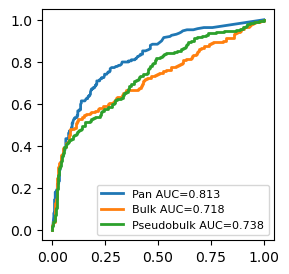

In [277]:
fig, ax = plt.subplots(figsize=(3,3))

## full length
temp_doublecheck = doublecheck.loc[~doublecheck['icSHAPE.reac.Pan'].isna()]
icshape_fpr, icshape_tpr, _ = roc_curve(temp_doublecheck['unpair'].astype("bool").to_list(),temp_doublecheck['icSHAPE.reac.Pan'].to_list())
icshape_auc = roc_auc_score(temp_doublecheck['unpair'].astype("bool").to_list(),temp_doublecheck['icSHAPE.reac.Pan'].to_list())
ax.plot(icshape_fpr, icshape_tpr, marker='.', label='Pan AUC={}'.format(np.round(icshape_auc,3)), linewidth=2, markersize=0, ) #color="blue" 

## solvent accessibility
temp_doublecheck = doublecheck.loc[~doublecheck['bulk'].isna()]
icshape_fpr, icshape_tpr, _ = roc_curve(temp_doublecheck['unpair'].astype("bool").to_list(),temp_doublecheck['bulk'].to_list())
icshape_auc = roc_auc_score(temp_doublecheck['unpair'].astype("bool").to_list(),temp_doublecheck['bulk'].to_list())
ax.plot(icshape_fpr, icshape_tpr, marker='.', label='Bulk AUC={}'.format(np.round(icshape_auc,3)), linewidth=2, markersize=0, ) #color="blue" 

temp_doublecheck = doublecheck.loc[~doublecheck['single'].isna()]
icshape_fpr, icshape_tpr, _ = roc_curve(temp_doublecheck['unpair'].astype("bool").to_list(),temp_doublecheck['single'].to_list())
icshape_auc = roc_auc_score(temp_doublecheck['unpair'].astype("bool").to_list(),temp_doublecheck['single'].to_list())
ax.plot(icshape_fpr, icshape_tpr, marker='.', label='Pseudobulk AUC={}'.format(np.round(icshape_auc,3)), linewidth=2, markersize=0, ) #color="blue" 

plt.legend(fontsize=8)
plt.savefig("../Current_Figures/01. ROC_bulk_with_other_methods/ROC.Cliff_vs_BulkSingle.Cliff_Method.pdf")
plt.show()

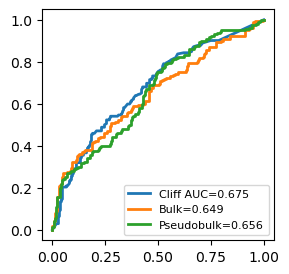

In [278]:
reac2db_df = pd.concat([rRNA_icSHAPE_df_sl, hg_rRNA_dotbrackets_df, scSHAPE_zy], axis=1, join="outer")
#reac2db_df = reac2db_df.dropna()

fig, ax = plt.subplots(figsize=(3,3))

## full length
#icshape_fpr, icshape_tpr, _ = roc_curve(reac2db_df['unpair'].astype("bool").to_list(), reac2db_df['sl.shape.reac'].to_list())
#icshape_auc = roc_auc_score(reac2db_df['unpair'].astype("bool").to_list(), reac2db_df['sl.shape.reac'].to_list())
#ax.plot(icshape_fpr, icshape_tpr, marker='.', label='50-1650 nt AUC={}'.format(np.round(icshape_auc,3)), linewidth=2, markersize=0, ) #color="blue" 

## solvent accessibility

local_reac2db_df = reac2db_df.loc[reac2db_df['solvent_accessibility']>=3]
local_reac2db_df = local_reac2db_df.loc[~local_reac2db_df['sl.shape.reac'].isna()]
local_reac2db_df = local_reac2db_df.loc[local_reac2db_df.index.isin(list(range(50,1850)))]
icshape_fpr, icshape_tpr, _ = roc_curve(local_reac2db_df['unpair'].astype("bool").to_list(), local_reac2db_df['sl.shape.reac'].to_list())
icshape_auc = roc_auc_score(local_reac2db_df['unpair'].astype("bool").to_list(), local_reac2db_df['sl.shape.reac'].to_list())
ax.plot(icshape_fpr, icshape_tpr, marker='.', label='Cliff AUC={}'.format(np.round(icshape_auc,3)), linewidth=2, markersize=0, ) #color="blue" 

local_reac2db_df = reac2db_df.loc[reac2db_df['solvent_accessibility']>=3]
local_reac2db_df = local_reac2db_df.loc[~local_reac2db_df['bulk'].isna()]
local_reac2db_df = local_reac2db_df.loc[local_reac2db_df.index.isin(list(range(50,1700)))]
icshape_fpr, icshape_tpr, _ = roc_curve(local_reac2db_df['unpair'].astype("bool").to_list(), local_reac2db_df['bulk'].to_list())
icshape_auc = roc_auc_score(local_reac2db_df['unpair'].astype("bool").to_list(), local_reac2db_df['bulk'].to_list())
ax.plot(icshape_fpr, icshape_tpr, marker='.', label='Bulk={}'.format(np.round(icshape_auc,3)), linewidth=2, markersize=0, ) #color="blue" 


local_reac2db_df = reac2db_df.loc[reac2db_df['solvent_accessibility']>=3]
local_reac2db_df = local_reac2db_df.loc[~local_reac2db_df['single'].isna()]
local_reac2db_df = local_reac2db_df.loc[local_reac2db_df.index.isin(list(range(50,1700)))]
icshape_fpr, icshape_tpr, _ = roc_curve(local_reac2db_df['unpair'].astype("bool").to_list(), local_reac2db_df['single'].to_list())
icshape_auc = roc_auc_score(local_reac2db_df['unpair'].astype("bool").to_list(), local_reac2db_df['single'].to_list())
ax.plot(icshape_fpr, icshape_tpr, marker='.', label='Pseudobulk={}'.format(np.round(icshape_auc,3)), linewidth=2, markersize=0, ) #color="blue" 
plt.legend(fontsize=8)
plt.savefig("../Current_Figures/01. ROC_bulk_with_other_methods/ROC.Cliff_vs_BulkSingle.Our_Method.pdf")
plt.show()

### single cells AUC with Cliff Method

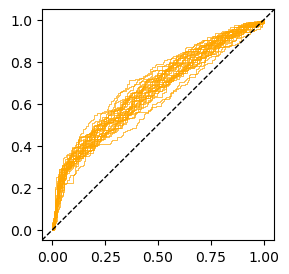

In [284]:
## hg rRNA, scSHAPE
rRNA_scSHAPE_df = load_large_dataFrame("../Current_Data/04.Wide_Reac_Matrix_1nt/bulk2single.h9.rRNA.crude_reac.csv", header=[0,1,2,3], index_col=[0,1])
rRNA_scSHAPE_df = rRNA_scSHAPE_df.xs("batch_1", level="batch", axis=1)
rRNA_scSHAPE_singles = rRNA_scSHAPE_df.xs("single", level="lib_type", axis=1)
rRNA_scSHAPE_singles


fig, ax = plt.subplots(figsize=(3,3))
## Pan
"""temp_doublecheck = doublecheck.loc[~doublecheck['icSHAPE.reac.Pan'].isna()]
icshape_fpr, icshape_tpr, _ = roc_curve(temp_doublecheck['unpair'].astype("bool").to_list(),temp_doublecheck['icSHAPE.reac.Pan'].to_list())
icshape_auc = roc_auc_score(temp_doublecheck['unpair'].astype("bool").to_list(),temp_doublecheck['icSHAPE.reac.Pan'].to_list())
ax.plot(icshape_fpr, icshape_tpr, marker='.', label='Pan AUC={}'.format(np.round(icshape_auc,3)), linewidth=1, markersize=0, ) #color="blue" """

auc_lst = []

for (sample, stage), col in rRNA_scSHAPE_singles.items():
    single_df = col.to_frame('single')
    single_df = single_df.loc['human_small']
    
    doublecheck = pd.concat([icSHAPE_Pan, single_df], axis=1)
    #doublecheck = doublecheck.loc[doublecheck['Benchmark'].notna()]
    doublecheck['unpair'] = doublecheck['Benchmark'] == "."
    
    doublecheck = doublecheck.loc[((doublecheck['acc'].isna())|(doublecheck['acc']>=3))&
                                       ((doublecheck.index<800)|(doublecheck.index>920))]
    
    
    #print (doublecheck)

    temp_doublecheck = doublecheck.loc[~doublecheck['single'].isna()]
    icshape_fpr, icshape_tpr, _ = roc_curve(temp_doublecheck['unpair'].astype("bool").to_list(),temp_doublecheck['single'].to_list())
    icshape_auc = roc_auc_score(temp_doublecheck['unpair'].astype("bool").to_list(),temp_doublecheck['single'].to_list())
    ax.plot(icshape_fpr, icshape_tpr, marker='.', label='{} AUC={}'.format(sample, np.round(icshape_auc,3)), linewidth=0.5, markersize=0, color="orange")
    auc_lst.append(icshape_auc)
ax.axline((0,0),(1,1),lw=1,ls='--',color="black")
#plt.legend(fontsize=8, loc=[1.05,0], ncol=3)
#plt.subplots_adjust(left=0.1, right=0.6, top=0.9, bottom=0.4)
plt.savefig("../Current_Figures/01. ROC_bulk_with_other_methods/ROC.Cliff_vs_BulkSingle.Cliff_Method.single.pdf")
plt.show()

In [288]:
max(auc_lst)

0.7090426822925696

In [233]:
stacked_rRNA_scSHAPE_df = rRNA_scSHAPE_df.stack().to_frame('reac').reset_index()
stacked_rRNA_scSHAPE_df

"""fig, axs = plt.subplots(4, 1, figsize=(16,8), sharey=True)
n = 0
for lib_type in ['bulk','cell_100', 'cell_10', 'single']:
    subset = stacked_rRNA_scSHAPE_df.loc[stacked_rRNA_scSHAPE_df['lib_type']==lib_type]
    sns.lineplot(data=subset, x='pos', y="reac", ax=axs[n])
    n+=1
plt.show()"""

rRNA_scSHAPE_df
rRNA_scSHAPE_df.index = rRNA_scSHAPE_df.index.get_level_values('pos')
rRNA_scSHAPE_df.index.name = 'Nucleotide'
#rRNA_scSHAPE_df = rRNA_scSHAPE_df.loc[rRNA_scSHAPE_df.index%5 == 0]
#rRNA_scSHAPE_df = rRNA_scSHAPE_df.loc[rRNA_scSHAPE_df.index<1700]
#rRNA_scSHAPE_df = rRNA_scSHAPE_df.loc[rRNA_scSHAPE_df.index>100]
rRNA_scSHAPE_df

acc_zy = load_large_dataFrame("../../../../FigureFactory/rRNA_ROC/human_18S.txt", sep="\t", header=None, index_col=None)
acc_zy.columns = ['Nucleotide','nt','solvent_accessibility']
acc_zy= acc_zy.set_index('Nucleotide')
acc_zy

scSHAPE_zy = pd.concat([rRNA_scSHAPE_df, acc_zy], axis=1)
scSHAPE_zy.sort_index()

AttributeError: 'DataFrame' object has no attribute 'to_frame'

### plot stem-loop boundary 

In [5]:
human_18S_seq = 'UACCUGGUUGAUCCUGCCAGUAGCAUAUGCUUGUCUCAAAGAUUAAGCCAUGCAUGUCUAAGUACGCACGGCCGGUACAGUGAAACUGCGAAUGGCUCAUUAAAUCAGUUAUGGUUCCUUUGGUCGCUCGCUCCUCUCCUACUUGGAUAACUGUGGUAAUUCUAGAGCUAAUACAUGCCGACGGGCGCUGACCCCCUUCGCGGGGGGGAUGCGUGCAUUUAUCAGAUCAAAACCAACCCGGUCAGCCCCUCUCCGGCCCCGGCCGGGGGGCGGGCGCCGGCGGCUUUGGUGACUCUAGAUAACCUCGGGCCGAUCGCACGCCCCCCGUGGCGGCGACGACCCAUUCGAACGUCUGCCCUAUCAACUUUCGAUGGUAGUCGCCGUGCCUACCAUGGUGACCACGGGUGACGGGGAAUCAGGGUUCGAUUCCGGAGAGGGAGCCUGAGAAACGGCUACCACAUCCAAGGAAGGCAGCAGGCGCGCAAAUUACCCACUCCCGACCCGGGGAGGUAGUGACGAAAAAUAACAAUACAGGACUCUUUCGAGGCCCUGUAAUUGGAAUGAGUCCACUUUAAAUCCUUUAACGAGGAUCCAUUGGAGGGCAAGUCUGGUGCCAGCAGCCGCGGUAAUUCCAGCUCCAAUAGCGUAUAUUAAAGUUGCUGCAGUUAAAAAGCUCGUAGUUGGAUCUUGGGAGCGGGCGGGCGGUCCGCCGCGAGGCGAGCCACCGCCCGUCCCCGCCCCUUGCCUCUCGGCGCCCCCUCGAUGCUCUUAGCUGAGUGUCCCGCGGGGCCCGAAGCGUUUACUUUGAAAAAAUUAGAGUGUUCAAAGCAGGCCCGAGCCGCCUGGAUACCGCAGCUAGGAAUAAUGGAAUAGGACCGCGGUUCUAUUUUGUUGGUUUUCGGAACUGAGGCCAUGAUUAAGAGGGACGGCCGGGGGCAUUCGUAUUGCGCCGCUAGAGGUGAAAUUCCUUGGACCGGCGCAAGACGGACCAGAGCGAAAGCAUUUGCCAAGAAUGUUUUCAUUAAUCAAGAACGAAAGUCGGAGGUUCGAAGACGAUCAGAUACCGUCGUAGUUCCGACCAUAAACGAUGCCGACCGGCGAUGCGGCGGCGUUAUUCCCAUGACCCGCCGGGCAGCUUCCGGGAAACCAAAGUCUUUGGGUUCCGGGGGGAGUAUGGUUGCAAAGCUGAAACUUAAAGGAAUUGACGGAAGGGCACCACCAGGAGUGGAGCCUGCGGCUUAAUUUGACUCAACACGGGAAACCUCACCCGGCCCGGACACGGACAGGAUUGACAGAUUGAUAGCUCUUUCUCGAUUCCGUGGGUGGUGGUGCAUGGCCGUUCUUAGUUGGUGGAGCGAUUUGUCUGGUUAAUUCCGAUAACGAACGAGACUCUGGCAUGCUAACUAGUUACGCGACCCCCGAGCGGUCGGCGUCCCCCAACUUCUUAGAGGGACAAGUGGCGUUCAGCCACCCGAGAUUGAGCAAUAACAGGUCUGUGAUGCCCUUAGAUGUCCGGGGCUGCACGCGCGCUACACUGACUGGCUCAGCGUGUGCCUACCCUACGCCGGCAGGCGCGGGUAACCCGUUGAACCCCAUUCGUGAUGGGGAUCGGGGAUUGCAAUUAUUCCCCAUGAACGAGGAAUUCCCAGUAAGUGCGGGUCAUAAGCUUGCGUUGAUUAAGUCCCUGCCCUUUGUACACACCGCCCGUCGCUACUACCGAUUGGAUGGUUUAGUGAGGCCCUCGGAUCGGCCCCGCCGGGGUCGGCCCACGGCCCUGGCGGAGCGCUGAGAAGACGGUCGAACUUGACUAUCUAGAGGAAGUAAAAGUCGUAACAAGGUUUCCGUAGGUGAACCUGCGGAAGGAUCAUUA'
# 18S Reference structure
human_18S_dot = '...(((((...<<<.))))).((.(((((((..(.((..((.....(((.(((..((...(((....((..........))...)))))......(((.......(((...(..((....(((..................(.((.....((.(((.....))).))......)).).......((((...((((((....))))))...))))....(((((........(((((.((((...((((.((((((((....))))))))..)))).)))).....))))).......)))))...........((((.((((......))))))))....)))...)))...))).(((....(((....(((((((.........))))))))))......)))...((((((((....))))...))))))).((.(((..........))).)).(.((....)).)...)))))).).....(.(((...(((((...))))).)))).)...)).).....(((((((((.(((....)))..)))))).)))......((..(...........)..)).........((((((<<<....((((.....((.>>>)).......)))))))))).))))))).))..........(.(<<.....(.((...(((.......(((.(((((((((((((.((((....))))....))))))))..)))))))).......((((.(((((...(((((((......)))))))....)))))))))................................................................................................................................((((((..(...((((..((..((((((((...(((......))).......))))))))..)).......((....))...))))..)..)).))))...)))...)).)....((((((....(...((((.........))))...).))))))..........((((((.(((..(.((((((.(((((....))))))))))).)..)))...((..>>))...)))....))).).)..(((.....((((....))))....)))...>>>..(((((.(((((((..((..((((((.(((.((((((....((((........))))........(((((.(....(((((........((.(((........))).))......)))))...((.((((..((((((((....(((.(((((....)))...(((......)))...)).))).....(.((.(.(.((((..((((....(((..((((....)))).)))....))))..))))).)..(..(((((.....)))))..)....)).)....))).)))...).))))))).....).)))))...)).)))).))).)...((.(((......(((.......((..((((....))))..)).....)))......))).))......(.....(((((..........))))).....).....))))).....((((((((.......))))))))......))...)))))))))).))....(..((.(..((((.((..(.((((((((.(((..((((.((...(((((.((((((((((((.....))))))))))))...)))))...)).))))..))).)))))))))..)).))))...).))...)....((((((((((....))))))))))........'
# 18S accessibility from PDB(6ek0)
human_18S_acc = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.55, 0.0, 0.0, 0.0, 0.0, 1.22, 0.0, 0.0, 28.48, 13.71, 6.37, 50.84, 26.24, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 31.1, 56.09, 13.34, 52.37, 0.0, 71.04, 51.03, 52.46, 0.0, 0.0, 0.0, 52.44, 46.09, 65.94, 6.21, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.14, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.62, 0.0, 0.0, 0.0, 1.6, 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 16.18, 0.0, 0.0, 8.67, 0.0, 5.38, 9.9, 6.26, 29.1, 1.89, 0.0, 0.0, 0.0, 5.9, 0.0, 0.0, 0.0, 0.0, 0.0, 13.15, 2.53, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.29, 29.94, 14.54, 19.29, 0.0, 2.01, 9.35, 0.0, 0.0, 0.0, 72.33, 18.4, 54.15, 0.57, 0.0, 0.0, 12.14, 0.0, 76.17, 57.36, 20.43, 19.36, 3.91, 65.2, 0.69, 0.0, 0.0, 67.8, 14.57, 63.68, 0.0, 32.18, 56.31, 60.13, 53.23, 0.62, 70.59, 62.05, 57.17, 18.31, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 39.39, 42.01, 0.0, 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 0.0, 0.0, 0.0, 9.49, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.17, 34.71, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.32, 18.73, 0.0, 1.13, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.28, 85.92, 4.82, 36.11, 20.49, 8.28, 0.0, 0.0, 99.86, 0.0, 41.22, 0.0, 47.39, 33.21, 33.58, 24.27, 58.45, 39.87, 0.0, 0.0, 0.0, 3.71, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.63, 0.0, 0.0, 0.0, 1.72, 0.69, 7.43, 13.32, 0.0, 0.0, 0.0, 0.0, 0.0, 1.15, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.53, 0.0, 0.0, 0.0, 0.0, 18.09, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.77, 0.0, 0.58, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.98, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.76, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.25, 17.14, 0.63, 0.0, 1.19, 11.02, 0.0, 0.0, 3.07, 0.0, 0.0, 0.0, 4.63, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.27, 31.9, 57.85, 12.85, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 47.8, 0.58, 0.0, 0.0, 0.0, 15.65, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.89, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.29, 34.59, 8.53, 0.0, 0.0, 0.0, 0.58, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.28, 43.72, 24.22, 49.1, 25.01, 38.4, 21.94, 0.0, 20.25, 87.97, 0.0, 11.48, 13.75, 27.8, 39.72, 60.03, 13.48, 52.86, 0.0, 0.0, 71.49, 48.94, 30.34, 0.0, 0.0, 20.67, 53.6, 0.0, 13.48, 80.73, 0.0, 0.0, 0.0, 18.9, 0.0, 0.0, 0.0, 0.69, 45.27, 81.35, 18.51, 101.78, 51.13, 0.0, 0.0, 0.0, 0.0, 0.0, 55.3, 57.12, 17.95, 0.0, 2.4, 0.0, 0.0, 4.05, 72.77, 65.83, 63.31, 2.91, 0.0, 0.0, 0.0, 0.0, 25.44, 0.0, 6.78, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.33, 8.83, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.85, 51.59, 24.04, 0.0, 0.0, 0.0, 9.79, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.29, 0.0, 0.0, 0.0, 31.49, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.39, 36.79, 4.26, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.58, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.71, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 45.65, 21.95, 0.0, 86.46, 54.81, 0.0, 37.57, 0.0, 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 0.0, 40.26, 0.0, 44.66, 0.0, 6.28, 8.55, 33.29, 0.0, 86.85, 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 0.0, 0.0, 16.88, 46.17, 2.91, 0.0, 53.27, 85.97, 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 3.99, 37.52, 6.65, 82.07, 84.11, 0.0, 0.0, 1.39, 26.03, 26.95, 1.15, 0.0, 0.0, 0.56, 0.0, 2.75, 0.0, 0.0, 0.0, 7.73, 26.98, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.93, 1.14, 0.0, 0.0, 0.0, 0.0, 0.69, 9.03, 0.0, 0.0, 0.0, 0.0, 0.0, 12.41, 0.0, 0.0, 0.0, 0.0, 8.94, 48.22, 0.0, 87.7, 0.0, 1.15, 0.0, 0.0, 0.0, 27.99, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 40.65, 0.0, 0.57, 0.0, 0.0, 0.0, 0.0, 0.0, 24.96, 42.61, 0.0, 0.0, 0.0, 0.0, 0.0, 16.09, 0.0, 1.24, 0.0, 0.0, 4.07, 0.0, 0.0, 0.0, 0.0, 0.0, 32.28, 62.55, 42.81, 49.17, 76.01, 50.88, 67.59, 58.66, 19.48, 12.22, 72.41, 0.0, 0.0, 7.14, 53.26, 27.24, 64.57, 65.84, 73.09, 57.21, 0.0, 84.84, 3.48, 39.38, 4.86, 5.85, 0.6, 8.92, 13.53, 35.75, 11.57, 51.87, 66.73, 32.07, 54.48, 10.0, 0.0, 0.63, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.24, 0.0, 0.0, 0.0, 9.45, 0.62, 8.6, 1.13, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 40.21, 30.17, 58.19, 40.1, 0.0, 0.0, 0.0, 0.0, 15.81, 0.0, 0.0, 0.0, 0.0, 0.0, 8.5, 0.0, 13.98, 0.0, 0.0, 0.0, 'NULL', 0.0, 0.0, 37.31, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.34, 43.22, 1.19, 3.64, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 35.85, 29.34, 35.11, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.13, 5.37, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.86, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.39, 0.0, 0.0, 0.0, 10.31, 2.93, 16.91, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.02, 0.0, 0.0, 0.0, 0.0, 0.0, 18.85, 0.0, 0.0, 0.0, 0.0, 0.0, 8.75, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.05, 39.54, 2.35, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.44, 27.72, 14.5, 0.0, 18.77, 0.0, 0.0, 0.0, 0.0, 30.8, 41.36, 0.0, 16.99, 24.27, 0.0, 0.0, 0.0, 0.0, 0.57, 11.77, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.11, 45.61, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.37, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.56, 5.29, 0.0, 1.82, 0.0, 0.0, 0.0, 20.08, 3.12, 0.57, 1.76, 1.14, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.62, 0.0, 0.0, 4.31, 0.0, 0.0, 0.0, 0.0, 0.58, 0.0, 1.22, 2.63, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 19.19, 0.0, 0.0, 2.57, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.46, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.17, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.81, 0.0, 0.0, 0.0, 76.83, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.49, 49.76, 48.89, 53.65, 57.01, 4.54, 0.0, 0.0, 0.62, 0.0, 0.0, 0.0, 2.33, 18.09, 0.0, 3.79, 0.0, 45.75, 50.22, 2.99, 0.0, 0.0, 0.0, 3.04, 0.0, 0.0, 0.0, 10.62, 46.82, 50.56, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 49.96, 50.98, 64.67, 58.39, 7.35, 0.0, 0.0, 0.0, 0.0, 0.0, 8.47, 46.36, 0.0, 0.0, 1.15, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.51, 0.0, 15.58, 0.0, 0.0, 0.0, 0.0, 0.0, 5.25, 43.0, 0.0, 0.0, 0.57, 58.46, 0.62, 0.0, 0.0, 0.0, 0.0, 14.4, 0.62, 0.0, 0.0, 0.0, 59.65, 24.22, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.96, 0.0, 1.78, 0.0, 0.0, 24.09, 33.67, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.41, 9.94, 0.0, 0.0, 0.56, 0.0, 0.0, 0.0, 0.0, 0.0, 17.1, 11.25, 36.16, 61.63, 27.31, 0.0, 0.0, 0.0, 5.21, 0.0, 0.0, 0.0, 0.0, 5.12, 3.48, 4.59, 0.0, 0.0, 0.0, 0.0, 2.42, 41.2, 19.39, 0.0, 1.77, 56.49, 0.0, 0.0, 0.0, 28.07, 29.75, 5.9, 0.0, 0.0, 0.0, 0.0, 0.0, 3.09, 0.0, 43.81, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37.31, 51.39, 47.82, 47.92, 0.0, 0.0, 5.42, 0.0, 0.0, 0.0, 21.39, 38.95, 44.97, 28.18, 32.15, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.1, 14.98, 0.0, 0.0, 0.0, 0.62, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.43, 16.44, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.81, 0.0, 32.92, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.69, 27.86, 59.18, 63.78, 3.8, 0.0, 0.0, 0.0, 0.0, 39.02, 61.76, 56.35, 33.51, 10.53, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.95, 0.0, 0.0, 0.0, 0.0, 2.85, 0.0, 0.0, 0.0, 0.0, 0.0, 2.97, 0.0, 25.45, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.46, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.55, 0.0, 18.52, 0.0, 0.0, 0.0, 0.0, 5.46, 28.7, 61.0, 16.3, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.69, 0.0, 5.75, 0.57, 0.0, 0.0, 0.0, 0.0, 0.63, 0.58, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.23, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.58, 8.75, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.54, 0.0, 3.89, 30.12, 57.55, 33.83, 0.0, 11.26, 21.14, 0.0, 0.0, 31.61, 16.7, 3.01, 0.0, 0.0, 0.0, 0.0, 0.0, 2.86, 28.35, 24.52, 0.0, 11.03, 0.0, 0.58, 6.87, 4.56, 44.31, 20.03, 21.86, 0.0, 0.0, 82.19, 0.0, 54.43, 0.0, 0.0, 0.0, 4.43, 0.0, 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 'NULL', 53.69, 45.96, 0.0, 13.84, 0.0, 15.57, 24.65, 36.09, 14.82, 16.99, 0.0, 5.7, 0.0, 38.89, 0.0, 22.23, 22.16, 36.5, 0.57, 0.0, 0.0, 1.14, 0.0, 3.39, 0.69, 3.49, 0.0, 0.0, 0.0, 0.0, 0.0, 15.76, 43.48, 5.24, 0.0, 0.0, 33.76, 0.0, 0.0, 23.77, 31.15, 44.69, 55.13, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6, 21.89, 81.31, 0.0, 0.0, 0.0, 0.0, 28.83, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.91, 0.0, 0.0, 0.0, 4.81, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.15, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.58]
human_18S_seq = list(human_18S_seq)
human_18S_dot = list(human_18S_dot)


del human_18S_seq[968]
del human_18S_dot[968]
del human_18S_acc[968]

benchmark_Pan = pd.DataFrame([list(human_18S_seq), list(human_18S_dot), human_18S_acc]).T
benchmark_Pan.columns = ['Base','Benchmark','Acc']
benchmark_Pan['Acc'] = benchmark_Pan['Acc'].replace("NULL", np.nan) 
benchmark_Pan['unpair'] = benchmark_Pan['Benchmark'] == "."
benchmark_Pan['pos'] = list(range(1,benchmark_Pan.index.size+1))
benchmark_Pan['gene'] = "human_small"
benchmark_Pan.set_index(['gene','pos'], inplace=True)
benchmark_Pan

Base Benchmark   Acc  unpair
gene        pos                              
human_small 1       U         .  0.00    True
            2       A         .  0.00    True
            3       C         .  0.00    True
            4       C         (  0.00   False
            5       U         (  0.00   False
...               ...       ...   ...     ...
            1865    C         .  0.00    True
            1866    A         .  0.00    True
            1867    U         .  0.00    True
            1868    U         .  0.00    True
            1869    A         .  9.58    True

[1869 rows x 4 columns]

In [6]:
previous = None
boundary_stem = 2
boundary_loop = 0
boundary_concat_lst = []
stem_concat_lst = []
loop_concat_lst = []

stem_temp_lst = []
loop_temp_lst = []
stem_len_thresh = 0
loop_len_thresh = 0


out_concat_lst = []
for (gene, pos), row in benchmark_Pan.sort_index().iterrows():
    
    if pos < 5:
        if row['unpair']:
            loop_concat_lst.append(row)
            #loop_temp_lst.append(pos)
        else:
            stem_concat_lst.append(row)
            #stem_temp_lst.append(pos)
        previous = row['unpair']
    elif previous == row['unpair']:
        if row['unpair']:
            loop_concat_lst.append(row)
            loop_temp_lst.append(pos)
        else:
            stem_concat_lst.append(row)
            stem_temp_lst.append(pos)
        previous = row['unpair']
    elif previous != row['unpair']:
        
        #print (previous, pos, row['unpair'])
        if previous == True:
            
            if len(loop_temp_lst) < (loop_len_thresh):
                loop_temp_lst.append(pos)
                #print (loop_temp_lst)
                pos_df = pd.DataFrame([loop_temp_lst], index=['pos']).T
                pos_df['gene'] = "human_small"
                pos_df = pos_df[['gene','pos']]
                out_df = benchmark_Pan.loc[pd.MultiIndex.from_frame(pos_df)]
                for local_row_id, local_row in out_df.iterrows():
                    loop_concat_lst.append(local_row)
                loop_temp_lst = []
                previous = row['unpair']
            else:
                pos_df = list(range((pos-boundary_loop), (pos+boundary_stem+1)))   
                pos_df = pd.DataFrame([pos_df], index=['pos']).T 
                pos_df['gene'] = "human_small"
                pos_df = pos_df[['gene','pos']]
                out_df = benchmark_Pan.loc[pd.MultiIndex.from_frame(pos_df)]
                out_df['boundary'] = "loop_to_stem"
                boundary_concat_lst.append(out_df)
                loop_temp_lst = []
                previous = row['unpair']
                
        elif previous == False:
            
            if len(stem_temp_lst) < (stem_len_thresh):
                stem_temp_lst.append(pos)
                #print (stem_temp_lst)
                pos_df = pd.DataFrame([stem_temp_lst], index=['pos']).T
                pos_df['gene'] = "human_small"
                pos_df = pos_df[['gene','pos']]
                out_df = benchmark_Pan.loc[pd.MultiIndex.from_frame(pos_df)]
                for local_row_id, local_row in out_df.iterrows():
                    stem_concat_lst.append(local_row)
                stem_temp_lst = []
                previous = row['unpair']
            else:
                pos_df = list(range((pos-boundary_stem), (pos+boundary_loop+1)))
                pos_df = pd.DataFrame([pos_df], index=['pos']).T
                pos_df['gene'] = "human_small"
                pos_df = pos_df[['gene','pos']]
                out_df = benchmark_Pan.loc[pd.MultiIndex.from_frame(pos_df)]
                out_df['boundary'] = "stem_to_loop"
                boundary_concat_lst.append(out_df) 
                stem_temp_lst = []
                previous = row['unpair']
boudary_df = pd.concat(boundary_concat_lst)
boudary_df = boudary_df.reset_index().drop_duplicates().set_index(['gene','pos']).sort_index()
uniq_boudary_df = boudary_df[['Base','Benchmark','Acc','unpair']].reset_index().drop_duplicates().set_index(['gene','pos']).sort_index()

boudary_df

stem_df = pd.concat(stem_concat_lst, axis=1).T
stem_df.index.names = ['gene','pos']
stem_df = stem_df.reset_index().drop_duplicates().set_index(['gene','pos']).sort_index()

loop_df = pd.concat(loop_concat_lst, axis=1).T
loop_df.index.names = ['gene','pos']
loop_df = loop_df.reset_index().drop_duplicates().set_index(['gene','pos']).sort_index()
loop_df = loop_df.reset_index().drop_duplicates().set_index(['gene','pos']).sort_index()


stem_df = stem_df.loc[~stem_df.index.isin(uniq_boudary_df.index)]
loop_df = loop_df.loc[~loop_df.index.isin(uniq_boudary_df.index)]

uniq_boudary_df['type'] = "Helix End"
stem_df['type'] = "Helix Middle"
loop_df['type'] = "Unpaired"
states_benchmark=pd.concat([uniq_boudary_df, stem_df, loop_df])
states_benchmark = states_benchmark.loc["human_small"]

In [7]:
previous = None
boundary_stem = 2
boundary_loop = 0
boundary_concat_lst = []
stem_concat_lst = []
loop_concat_lst = []

stem_temp_lst = []
loop_temp_lst = []
stem_len_thresh = 3
loop_len_thresh = 3


out_concat_lst = []
for (gene, pos), row in benchmark_Pan.sort_index().iterrows():
    
    if pos < 5:
        if row['unpair']:
            loop_concat_lst.append(row)
            #loop_temp_lst.append(pos)
        else:
            stem_concat_lst.append(row)
            #stem_temp_lst.append(pos)
        previous = row['unpair']
    elif previous == row['unpair']:
        if row['unpair']:
            loop_concat_lst.append(row)
            loop_temp_lst.append(pos)
        else:
            stem_concat_lst.append(row)
            stem_temp_lst.append(pos)
        previous = row['unpair']
    elif previous != row['unpair']:
        
        #print (previous, pos, row['unpair'])
        if previous == True:
            
            if len(loop_temp_lst) < (loop_len_thresh):
                loop_temp_lst.append(pos)
                #print (loop_temp_lst)
                pos_df = pd.DataFrame([loop_temp_lst], index=['pos']).T
                pos_df['gene'] = "human_small"
                pos_df = pos_df[['gene','pos']]
                out_df = benchmark_Pan.loc[pd.MultiIndex.from_frame(pos_df)]
                for local_row_id, local_row in out_df.iterrows():
                    loop_concat_lst.append(local_row)
                loop_temp_lst = []
                previous = row['unpair']
            else:
                pos_df = list(range((pos-boundary_loop), (pos+boundary_stem+1)))   
                pos_df = pd.DataFrame([pos_df], index=['pos']).T 
                pos_df['gene'] = "human_small"
                pos_df = pos_df[['gene','pos']]
                out_df = benchmark_Pan.loc[pd.MultiIndex.from_frame(pos_df)]
                out_df['boundary'] = "loop_to_stem"
                boundary_concat_lst.append(out_df)
                loop_temp_lst = []
                previous = row['unpair']
                
        elif previous == False:
            
            if len(stem_temp_lst) < (stem_len_thresh):
                stem_temp_lst.append(pos)
                #print (stem_temp_lst)
                pos_df = pd.DataFrame([stem_temp_lst], index=['pos']).T
                pos_df['gene'] = "human_small"
                pos_df = pos_df[['gene','pos']]
                out_df = benchmark_Pan.loc[pd.MultiIndex.from_frame(pos_df)]
                boundary_concat_lst.append(out_df)
                #for local_row_id, local_row in out_df.iterrows():
                #    stem_concat_lst.append(local_row)
                stem_temp_lst = []
                previous = row['unpair']
            else:
                pos_df = list(range((pos-boundary_stem), (pos+boundary_loop+1)))
                pos_df = pd.DataFrame([pos_df], index=['pos']).T
                pos_df['gene'] = "human_small"
                pos_df = pos_df[['gene','pos']]
                out_df = benchmark_Pan.loc[pd.MultiIndex.from_frame(pos_df)]
                out_df['boundary'] = "stem_to_loop"
                boundary_concat_lst.append(out_df) 
                stem_temp_lst = []
                previous = row['unpair']
boudary_df = pd.concat(boundary_concat_lst)
boudary_df = boudary_df.reset_index().drop_duplicates().set_index(['gene','pos']).sort_index()
uniq_boudary_df = boudary_df[['Base','Benchmark','Acc','unpair']].reset_index().drop_duplicates().set_index(['gene','pos']).sort_index()

boudary_df

stem_df = pd.concat(stem_concat_lst, axis=1).T
stem_df.index.names = ['gene','pos']
stem_df = stem_df.reset_index().drop_duplicates().set_index(['gene','pos']).sort_index()

loop_df = pd.concat(loop_concat_lst, axis=1).T
loop_df.index.names = ['gene','pos']
loop_df = loop_df.reset_index().drop_duplicates().set_index(['gene','pos']).sort_index()
loop_df = loop_df.reset_index().drop_duplicates().set_index(['gene','pos']).sort_index()


stem_df = stem_df.loc[~stem_df.index.isin(uniq_boudary_df.index)]
loop_df = loop_df.loc[~loop_df.index.isin(uniq_boudary_df.index)]

uniq_boudary_df['type'] = "Helix End"
stem_df['type'] = "Helix Middle"
loop_df['type'] = "Unpaired"
states_benchmark=pd.concat([uniq_boudary_df, stem_df, loop_df])
states_benchmark = states_benchmark.loc["human_small"]

In [8]:
print (uniq_boudary_df.index.size, stem_df.index.size, loop_df.index.size)
print (uniq_boudary_df.index.size+ stem_df.index.size+ loop_df.index.size)

799 232 838
1869


Unpaired        794
Helix End       750
Helix Middle    206
Name: type, dtype: int64


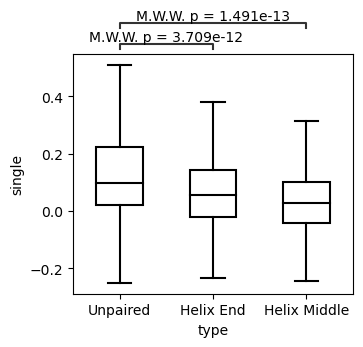

In [10]:
## hg rRNA, scSHAPE
rRNA_scSHAPE_df = load_large_dataFrame("../Current_Data/04.Wide_Reac_Matrix_1nt/bulk2single.h9.rRNA.gnorm_reac.csv", header=[0,1,2,3], index_col=[0,1])
rRNA_scSHAPE_df = rRNA_scSHAPE_df.xs("batch_1", level="batch", axis=1)
rRNA_scSHAPE_df = rRNA_scSHAPE_df.groupby(level=['lib_type'], axis=1).mean(numeric_only=True)
#rRNA_scSHAPE_df = smooth_by_avg_reac_of_rolling_wins(rRNA_scSHAPE_df, rolling_wins=3)
rRNA_scSHAPE_df

stacked_rRNA_scSHAPE_df = rRNA_scSHAPE_df.stack().to_frame('reac').reset_index()
stacked_rRNA_scSHAPE_df

"""fig, axs = plt.subplots(4, 1, figsize=(16,8), sharey=True)
n = 0
for lib_type in ['bulk','cell_100', 'cell_10', 'single']:
    subset = stacked_rRNA_scSHAPE_df.loc[stacked_rRNA_scSHAPE_df['lib_type']==lib_type]
    sns.lineplot(data=subset, x='pos', y="reac", ax=axs[n])
    n+=1
plt.show()"""

rRNA_scSHAPE_df
rRNA_scSHAPE_df.index = rRNA_scSHAPE_df.index.get_level_values('pos')
rRNA_scSHAPE_df.index.name = 'Nucleotide'
#rRNA_scSHAPE_df = rRNA_scSHAPE_df.dropna()
#rRNA_scSHAPE_df = rRNA_scSHAPE_df.loc[rRNA_scSHAPE_df.index%5 == 0]
rRNA_scSHAPE_df = rRNA_scSHAPE_df.loc[rRNA_scSHAPE_df.index<1800]
#rRNA_scSHAPE_df = rRNA_scSHAPE_df.loc[rRNA_scSHAPE_df.index>100]
rRNA_scSHAPE_df = rRNA_scSHAPE_df.merge(states_benchmark, left_index=True, right_index=True, validate="1:1")

t = pd.CategoricalDtype(categories=['Unpaired','Helix End','Helix Middle'])
rRNA_scSHAPE_df['type'] = rRNA_scSHAPE_df['type'].astype(t)
#rRNA_scSHAPE_df = rRNA_scSHAPE_df.loc[rRNA_scSHAPE_df['Acc']>=3]
fig, ax = plt.subplots(1,1,figsize=(4,4))

PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'}
}
sns.boxplot(data=rRNA_scSHAPE_df, x="type", y="single", showfliers=False, ax=ax, color='white', width=.5, fliersize=0,  **PROPS)

test_results = add_stat_annotation(ax, data=rRNA_scSHAPE_df, x="type", y="single", 
                                   box_pairs=[['Unpaired','Helix Middle'],
                                              ['Unpaired','Helix End'],
                                              ],
                                   test='Mann-Whitney', text_format='full',
                                   loc='outside', verbose=0.2, 
                                   comparisons_correction=None,
                                   line_offset_to_box=0.1, line_offset=0.02, line_height=0.02, text_offset=0.2)
#sns.stripplot(data=rRNA_scSHAPE_df, x="type", y="single", ax=ax, size=2, alpha=0.5, )
#sns.kdeplot(data=rRNA_scSHAPE_df, hue="type", x="single", common_norm=False)
#plt.xlim(-0.005, 0.04)
ax.set_position([0.2, 0.15, 0.7, 0.6])


print (rRNA_scSHAPE_df['type'].value_counts())
plt.savefig("../Current_Figures/01. ROC_bulk_with_other_methods/Boxplot.reactivity.3_states.ac_higher_than_3.norm_reac.pdf")
plt.show()

In [13]:
rRNA_scSHAPE_df = load_large_dataFrame("../Current_Data/04.Wide_Reac_Matrix_1nt/bulk2single.h9.rRNA.crude_reac.csv", header=[0,1,2,3], index_col=[0,1])
rRNA_scSHAPE_df = rRNA_scSHAPE_df.loc[rRNA_scSHAPE_df.index.get_level_values('pos')<1800]
rRNA_scSHAPE_df = rRNA_scSHAPE_df.xs("batch_1", level="batch", axis=1)
rRNA_scSHAPE_df = rRNA_scSHAPE_df.groupby(level=['lib_type'], axis=1).median(numeric_only=True)
rRNA_scSHAPE_df

lib_type              bulk   cell_10  cell_100    single
gene        pos                                         
human_small 2    -0.001553 -0.005342 -0.002781 -0.003065
            3     0.002972 -0.002331 -0.000905 -0.001637
            4    -0.005132 -0.006269 -0.004888 -0.001741
            5    -0.001382 -0.002854  0.001436  0.000848
            6    -0.001795 -0.001016 -0.000132 -0.000330
...                    ...       ...       ...       ...
            1795  0.000733  0.000748  0.000162 -0.002819
            1796  0.001197  0.002207  0.000697 -0.001884
            1797  0.001534  0.000877  0.000226 -0.001362
            1798  0.000484 -0.002368  0.000178 -0.000687
            1799 -0.000376  0.001260 -0.000339 -0.000917

[1798 rows x 4 columns]

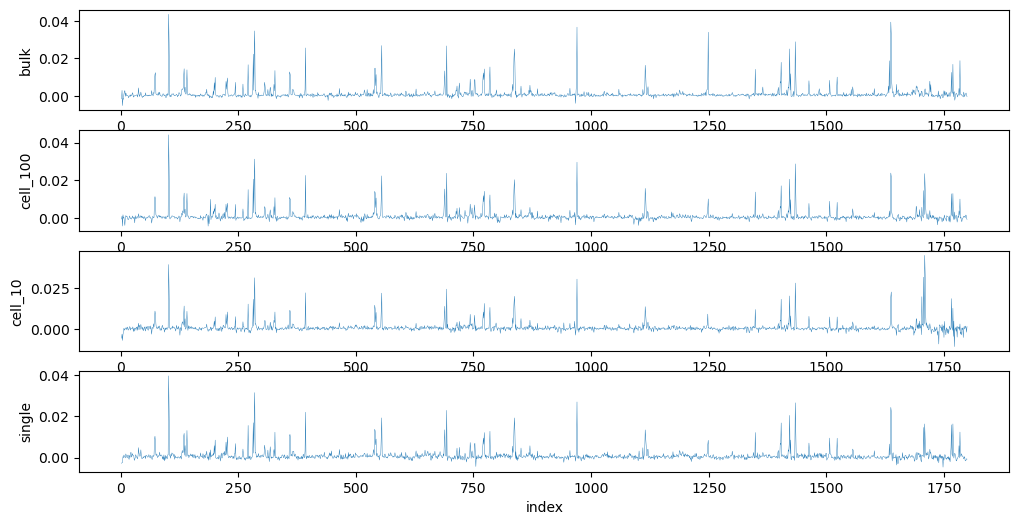

In [31]:
fig, axs = plt.subplots(4,1, figsize=(12,6))
n = 0 
for col in ["bulk","cell_100","cell_10","single"]:
    sns.lineplot(rRNA_scSHAPE_df.reset_index(), x="index", y=col, ax=axs[n], lw=0.3)
    n += 1
plt.show()

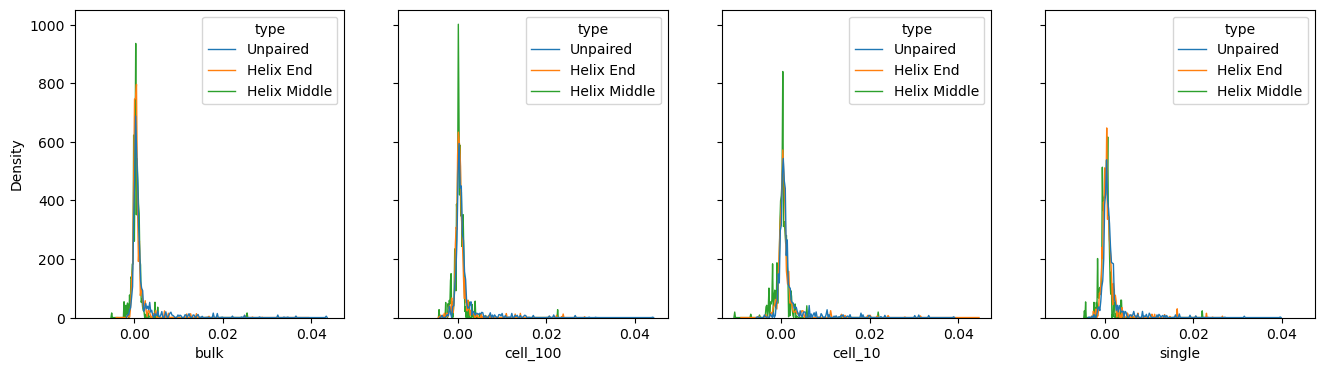

In [27]:
fig, axs = plt.subplots(1,4, figsize=(16,4), sharex=True, sharey=True)
n = 0 
for col in ["bulk","cell_100","cell_10","single"]:
    sns.kdeplot(rRNA_scSHAPE_df.reset_index(), x=col, ax=axs[n], hue="type", lw=1, common_norm=False, bw_adjust=0.05)
    n += 1
plt.show()

In [30]:
rRNA_scSHAPE_df

,bulk,cell_10,cell_100,single,Base,Benchmark,Acc,unpair,type
2,-0.001553,-0.005441,-0.000493,-0.002772,A,.,0.0,True,Unpaired
3,0.002972,-0.002990,0.001058,-0.002389,C,.,0.0,True,Unpaired
4,-0.005132,-0.006799,-0.004235,-0.002383,C,(,0.0,False,Helix Middle
5,-0.001382,-0.003265,0.001756,0.000518,U,(,0.0,False,Helix Middle
6,-0.001795,-0.001555,-0.000057,-0.000001,G,(,0.0,False,Helix Middle
...,...,...,...,...,...,...,...,...,...
1795,0.000733,0.000776,0.000195,-0.001340,G,),0.69,False,Unpaired
1796,0.001197,0.001903,0.001593,-0.001547,G,),3.49,False,Helix Middle
1797,0.001534,0.000843,0.001574,-0.001125,U,),0.0,False,Helix End
1798,0.000484,-0.001839,0.000072,-0.000513,C,),0.0,False,Helix End
